<h1>Live / offline difference</h1>

___

In [1]:
import sys
sys.path.insert(0, '/mxn/home/reblex/.local/lib/python3.8/site-packages')
from ptypy import io

from ptypy.utils import imsave
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import re
import ptypy.utils as u
from ptypy.utils import rmphaseramp
from skimage.restoration import unwrap_phase
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import ipywidgets as widgets
from matplotlib.gridspec import GridSpec
import h5py
%matplotlib widget
plt.ion()

WARNING ptypy - Message Passaging for Python (mpi4py) not found.
    CPU-parallelization disabled.
    Install python-mpi4py via the package repositories or with `pip install --user mpi4py`


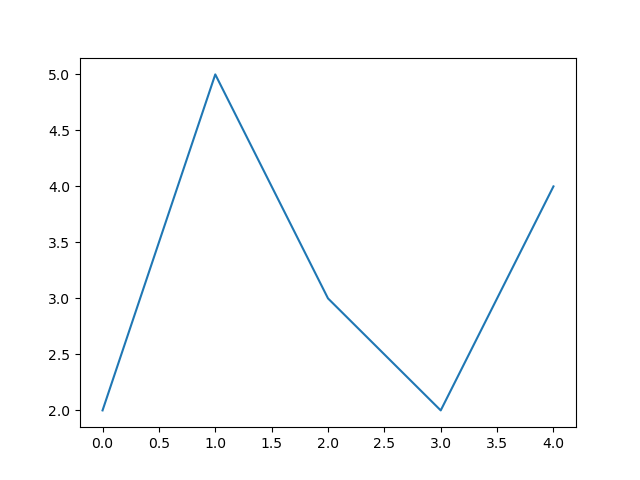

In [2]:
plt.figure()
plt.plot([2,5,3,2,4])

#### ___
<h2>Load and process data</h2>

___

<h3>Load data</h3>

In [3]:
#offline
filenames1 = {'54': '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_recons/from_simg_256px_Au-Si3N4_step10px_1e+10_poisTRUE_spiral_00/simg_startframe400__fpb25_GTpr-update_00/rec/rec_scan_000000_DM_pycuda_3000.ptyr'}
#live
filenames2 = {'54': '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_recons/from_simg_256px_Au-Si3N4_step10px_1e+10_poisTRUE_spiral_00/simg_startframe1____fpb25_GTpr-update_00/rec/rec_scan_000000_DM_pycuda_4692.ptyr'}

scan = '54'
samplename = {'54': '_spiralstep10px_1e10_GTpr-update'}
if scan not in samplename.keys():
    samplename[scan] = ''
    print('Obs! No sample name will be used when saving figures.')


fname1 = filenames1[scan]
#live
fname2 = filenames2[scan]

obj1 = io.h5read(fname1, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0]
obj2 = io.h5read(fname2, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0]
pr1 = io.h5read(fname1, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'][0]
pr2 = io.h5read(fname2, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'][0]

obj1_psize = io.h5read(fname1, 'content/obj/Sscan00G00/_psize')['content/obj/Sscan00G00/_psize'][0]
obj2_psize = io.h5read(fname2, 'content/obj/Sscan00G00/_psize')['content/obj/Sscan00G00/_psize'][0]


<h3>Process data</h3>

In [4]:
# Get the fnames of files containing the diffraction patterns:
dfile1 = glob.glob(fname1.rsplit('/',2)[0] + '/data/*.ptyd')[0]
dfile2 = glob.glob(fname2.rsplit('/',2)[0] + '/data/*.ptyd')[0]

diffraction1 = io.h5read(dfile1, 'chunks/0/data')['chunks/0/data']
diffraction2 = io.h5read(dfile2, 'chunks/0/data')['chunks/0/data']
mean_photons1 = np.sum(diffraction1)/diffraction1.shape[0]
mean_photons2 = np.sum(diffraction2)/diffraction2.shape[0]

print(mean_photons1, mean_photons2)


7845550490.12 7845550490.12


In [5]:
obj1_abs = np.abs(obj1)
obj2_abs = np.abs(obj2)
obj1_abslog = np.log(obj1_abs)
obj2_abslog = np.log(obj2_abs)

obj1_phase = np.angle(obj1)
obj2_phase = np.angle(obj2)

# Remove phase ramp
def rampweight(ob, scale=3):
    weights = np.zeros(ob.shape)#np.zeros_like(ob)
    M, N = weights.shape
    #weights[M // scale:M - M // scale, N // scale:N - N // scale] = 1  # centered box
    weights[int(M // scale):int(M - M // scale), int(N // scale):int(N - N // scale)] = 1  # centered box
    # weights[0:M - M // scale, N // scale:N - N // scale] = 1  # centered pillar
    #weights = np.abs(weights-1)  # Uncomment for inverting
    # always exlude a tiny bit on the edge
    mask = np.ones_like(weights, dtype=bool)
    edge = 30
    mask[ M//edge:M - M//edge , N//edge:N - N//edge  ] = False
    weights[mask] = 0
    return weights
w1 = rampweight(obj1, scale=10)#100) #5) #np.abs(rampweight(obj1, scale=3)-1)
w2 = rampweight(obj2, scale=10)#100) #5) #np.abs(rampweight(obj2, scale=3)-1)
#w1[:,:w1.shape[1]//2]=0  # only use the weights on the right side
#w2[:,:w2.shape[1]//2]=0  # only use the weights on the right side
# w1 = np.ones_like(obj1)
# w2 = np.ones_like(obj2)
obj1_ramp, ramp1 = rmphaseramp(obj1, w1, return_phaseramp=True)#rampweight(obj1, scale=3)
obj2_ramp, ramp2 = rmphaseramp(obj2, w2, return_phaseramp=True)
obj1_phaseramp = np.angle(obj1_ramp)
obj2_phaseramp = np.angle(obj2_ramp)
obj1_phaseramp_unwrapped = unwrap_phase(obj1_phaseramp) # unwrap_phase must have real input & output
obj2_phaseramp_unwrapped = unwrap_phase(obj2_phaseramp)
# ############################################################################################## ??????
#angle_trunc = lambda a: (a + np.ceil(abs(a) / (2 * np.pi)) * 2 * np.pi + np.pi) % (np.pi * 2) - np.pi # sets an array of radians into the interval (-pi, pi)
# obj1_phaseramp_unwrapped = angle_trunc(unwrap_phase(obj1_phaseramp)) # unwrap_phase must have real input & output
# obj2_phaseramp_unwrapped = angle_trunc(unwrap_phase(obj2_phaseramp))
# ############################################################################################## ??????
# shift1, error, phasediff = phase_cross_correlation(unwrap_phase(obj1_phaseramp)[100:-100,100:-100], unwrap_phase(obj2_phaseramp)[100:-100,100:-100], upsample_factor=100)

# diff_phase = obj1_phase - obj2_phase # goodplt.figure()
# diff_abslog_od = obj1_abslog - obj2_abslog # optical density
# diff_phaseramp_unwrappedshift = shift(obj1_phaseramp_unwrapped, [0.0, -0.15]) - obj2_phaseramp_unwrapped
# diff_phaseramp_unwrappedshift_ramp = np.angle(rmphaseramp(  np.exp(1j*diff_phaseramp_unwrappedshift), rampweight(np.exp(1j*diff_phaseramp_unwrappedshift), scale=3)  ))

obj1_rmramp_abs = np.abs(obj1_ramp)
obj2_rmramp_abs = np.abs(obj2_ramp)
obj1_rmramp_abslog = np.log(obj1_rmramp_abs)
obj2_rmramp_abslog = np.log(obj2_rmramp_abs)
diff_rmramp_abslog = obj1_rmramp_abslog - obj2_rmramp_abslog

diff_abslog_od = obj1_abslog - obj2_abslog # optical density
diff_phase = obj1_phase - obj2_phase
diff_phaseramp = obj1_phaseramp - obj2_phaseramp
diff_phaseramp_unwrapped = obj1_phaseramp_unwrapped - obj2_phaseramp_unwrapped
diff_phaseramp_unwrapped_ramp = np.angle(rmphaseramp(  np.exp(1j*diff_phaseramp_unwrapped), rampweight(np.exp(1j*diff_phaseramp_unwrapped), scale=3)  ))

marg = 100#500#250
shift1, error, phasediff = phase_cross_correlation(obj1_phaseramp_unwrapped[marg:-marg,marg:-marg], obj2_phaseramp_unwrapped[marg:-marg,marg:-marg], upsample_factor=1000)
# Update some differences according to the calculated shift between the offline-live recons.
#shift_val = np.array([-0.010, 0.565]) # [0.005, 0.604]
#obj2_phaseramp_unwrapped = shift(obj2_phaseramp_unwrapped, shift_val)#, [-0.015,  0.0  ])
#diff_phaseramp_unwrapped = obj1_phaseramp_unwrapped - obj2_phaseramp_unwrapped
#diff_phaseramp_unwrapped_ramp = np.angle(rmphaseramp(  np.exp(1j*diff_phaseramp_unwrapped), rampweight(np.exp(1j*diff_phaseramp_unwrapped), scale=3)  ))


# O = A * e^(i * phi) = e^(a + i* phi)
# A = np.abs(O)  # amplitude
# a = np.log(A)  # optical density


___
<h2>Plot data</h2>

___

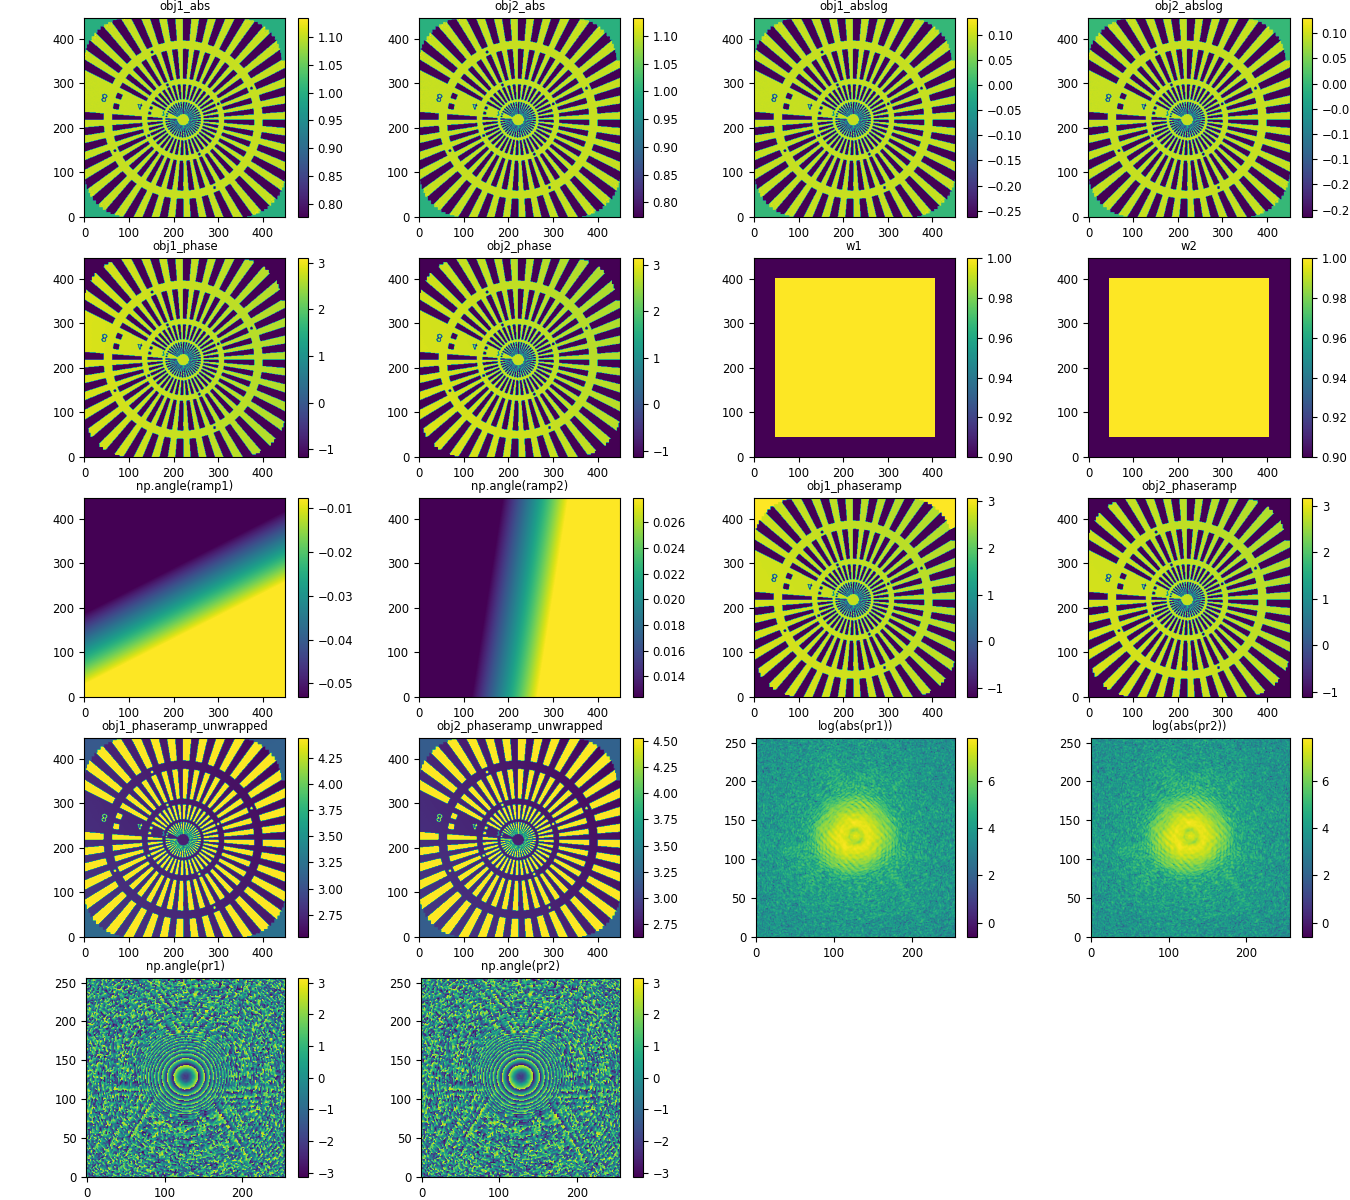

In [6]:
plt.cla()
plt.clf()
fig1 = plt.figure(num='First', figsize=(13.5, 12.0),tight_layout={'pad': 0.0})
fig1.subplots_adjust(left=0.03, bottom=0.05, right=0.97, top=0.9, wspace=0.33, hspace=0.2)
plt.rcParams['figure.titlesize'] = 'large' # default: 'large'
plt.rcParams['axes.titlesize'] = 'small' # default: 'large'
plt.rcParams['xtick.labelsize'] = 'small' # default: 'medium'
plt.rcParams['ytick.labelsize'] = 'small' # default: 'medium'

ax = [None]*18
gs1 = GridSpec(5, 8)
ax[0] = fig1.add_subplot(gs1[0, 0:2])
ax[1] = fig1.add_subplot(gs1[0, 2:4])
ax[2] = fig1.add_subplot(gs1[0, 4:6])
ax[3] = fig1.add_subplot(gs1[0, 6:8])

gs2 = GridSpec(5, 8)
ax[4] = fig1.add_subplot(gs2[1, 0:2])
ax[5] = fig1.add_subplot(gs2[1, 2:4])
ax[6] = fig1.add_subplot(gs2[1, 4:6])
ax[7] = fig1.add_subplot(gs2[1, 6:8])

gs3 = GridSpec(5, 8)
ax[8] = fig1.add_subplot(gs3[2, 0:2])
ax[9] = fig1.add_subplot(gs3[2, 2:4])
ax[10] = fig1.add_subplot(gs3[2, 4:6])
ax[11] = fig1.add_subplot(gs3[2, 6:8])

gs4 = GridSpec(5, 8)
ax[12] = fig1.add_subplot(gs4[3, 0:2])
ax[13] = fig1.add_subplot(gs4[3, 2:4])
ax[14] = fig1.add_subplot(gs4[3, 4:6])
ax[15] = fig1.add_subplot(gs4[3, 6:8])

gs5 = GridSpec(5, 8)
ax[16] = fig1.add_subplot(gs5[4, 0:2])
ax[17] = fig1.add_subplot(gs5[4, 2:4])
#ax[18] = fig1.add_subplot(gs5[4, 6:8])

im = [None]*18
im[0] = ax[0].imshow(obj1_abs, origin='lower')
im[1] = ax[1].imshow(obj2_abs, origin='lower')
im[2] = ax[2].imshow(obj1_abslog, origin='lower')
im[3] = ax[3].imshow(obj2_abslog, origin='lower')

im[4] = ax[4].imshow(obj1_phase, origin='lower') #
im[5] = ax[5].imshow(obj2_phase, origin='lower') #

im[6] = ax[6].imshow(np.abs(w1), origin='lower')
# im[6] = ax[6].imshow(np.abs(w1 + obj1_abs/5), origin='lower')  # Uncomment to show the object together with the weight
im[7] = ax[7].imshow(np.abs(w2), origin='lower')
# im[7] = ax[7].imshow(np.abs(w2 + obj2_abs/5), origin='lower')  # Uncomment to show the object together with the weight
im[8] = ax[8].imshow(np.angle(ramp1), origin='lower')
im[9] = ax[9].imshow(np.angle(ramp2), origin='lower')
im[10] = ax[10].imshow(obj1_phaseramp, origin='lower')
im[11] = ax[11].imshow(obj2_phaseramp, origin='lower')
im[12] = ax[12].imshow(obj1_phaseramp_unwrapped, origin='lower')
im[13] = ax[13].imshow(obj2_phaseramp_unwrapped, origin='lower')

im[14] = ax[14].imshow(np.log(np.abs(pr1)), origin='lower')
im[15] = ax[15].imshow(np.log(np.abs(pr2)), origin='lower')
im[16] = ax[16].imshow(np.angle(pr1), origin='lower')
im[17] = ax[17].imshow(np.angle(pr2), origin='lower')

for k in range(18):
    plt.colorbar(im[k], ax=ax[k], fraction=0.046, pad=0.04)

titles = ['obj1_abs', 'obj2_abs', 'obj1_abslog', 'obj2_abslog', 'obj1_phase', 'obj2_phase', 'w1', 'w2', 'np.angle(ramp1)', 'np.angle(ramp2)', 'obj1_phaseramp', 'obj2_phaseramp', 'obj1_phaseramp_unwrapped', 'obj2_phaseramp_unwrapped', 'log(abs(pr1))', 'log(abs(pr2))', 'np.angle(pr1)', 'np.angle(pr2)']


for n, title in enumerate(titles):
    plt.setp(ax[n], title=title)

def set_vminvmax(arr, std_factor):
    vmin = np.mean(arr[marg:-marg,marg:-marg]) - std_factor*np.std(arr[marg:-marg,marg:-marg])
    vmax = np.mean(arr[marg:-marg,marg:-marg]) + std_factor*np.std(arr[marg:-marg,marg:-marg])
    return vmin, vmax

# im[0].norm.vmin = 0.4
# im[0].norm.vmax = 0.6
# im[0].get_array()
for m in range(len(im)-4):
    im[m].set_clim(set_vminvmax(im[m].get_array().data, 1.0))

# im[0].set_clim(0.4, 0.6)
plt.show()



# lables = {'15': '_fpb50', '16': '_fpb20', '17': '_fpb300', '18': '_flip'}
# lable = lables[scan] if scan in lables.keys() else ''
# fig1.savefig(fname2.rsplit('/', 2)[0] + f'/data{lable}.png')

In [7]:
savefigs = True#False
if savefigs:
    lables = {'15': '_fpb50', '16': '_fpb20', '17': '_fpb300', '18': '_flip'}
    lable = lables[scan] if scan in lables.keys() else samplename[scan]
    fig1.savefig(fname2.rsplit('/', 2)[0] + f'/data{lable}.png')

___
<h2>Plot differences</h2>

___

<h4>Before shift correction</h4>

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 UPDATE NEW ENTRANCE IN slider_values WITH KEY , '54': [0.11, 0.8, 0.8, 1.1, 0.8]
 --------------------------------------------------------------------------------
--------------------------------------------------------------------------------



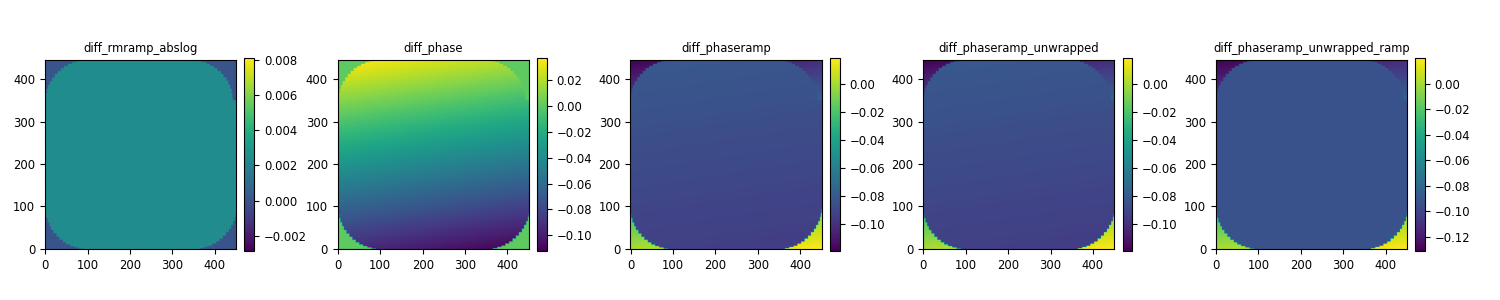

In [8]:
angle_trunc = lambda a: (a + np.ceil(abs(a) / (2 * np.pi)) * 2 * np.pi + np.pi) % (np.pi * 2) - np.pi # sets an array of radians into the interval (-pi, pi)

# obj2_phaseramp_unwrapped = shift(obj2_phaseramp_unwrapped, shift1)#[-0.0,  0.0  ])
# diff_phaseramp_unwrapped = obj1_phaseramp_unwrapped - obj2_phaseramp_unwrapped
# diff_phaseramp_unwrapped_ramp = np.angle(rmphaseramp(  np.exp(1j*diff_phaseramp_unwrapped), rampweight(np.exp(1j*diff_phaseramp_unwrapped), scale=3)  ))

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(3 * 5, 3))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
subfig0 = axs[0].imshow(diff_rmramp_abslog, origin='lower')#norm=mpl.colors.LogNorm(vmin=2.27e-02))
subfig1 = axs[1].imshow(angle_trunc(diff_phase), origin='lower')
subfig2 = axs[2].imshow(angle_trunc(diff_phaseramp), origin='lower')
subfig3 = axs[3].imshow(angle_trunc(diff_phaseramp_unwrapped), origin='lower')
subfig4 = axs[4].imshow(angle_trunc(diff_phaseramp_unwrapped_ramp), origin='lower')
plt.colorbar(subfig0, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig1, ax=axs[1], fraction=0.046, pad=0.04)
plt.colorbar(subfig2, ax=axs[2], fraction=0.046, pad=0.04)
plt.colorbar(subfig3, ax=axs[3], fraction=0.046, pad=0.04)
plt.colorbar(subfig4, ax=axs[4], fraction=0.046, pad=0.04)
plt.setp(axs[0], title='diff_rmramp_abslog')
plt.setp(axs[1], title='diff_phase')
plt.setp(axs[2], title='diff_phaseramp')
plt.setp(axs[3], title='diff_phaseramp_unwrapped')
plt.setp(axs[4], title='diff_phaseramp_unwrapped_ramp')

# Modified from https://github.com/matplotlib/matplotlib/issues/18563/
slider_values = {'0': [0.2, 1.2, 0.3, 4.0, 0.1], '1': [0.11, 0.8, 0.8, 1.1, 0.8], '2': [0.11, 1.2, 0.6, 1.5, 0.5], '3': [0.07, 0.8, 0.20, 1.2, 0.4], 
                '4': [0.11, 0.8, 0.8, 1.1, 0.8], '5': [0.11, 0.8, 0.8, 1.1, 0.8], '6': [0.11, 0.8, 0.8, 1.1, 0.8], '7': [0.11, 0.8, 0.8, 1.1, 0.8],
                '8': [1.0, 1.5, 1.8, 1.8, 1.8], '9': [0.11, 0.8, 0.8, 0.8, 0.8], '10': [0.11, 3.0, 2.0, 0.5, 0.5]}
if scan not in slider_values.keys():  # make sure there's an initial value for every scan-set.
    slider_values[scan] = [0.11, 0.8, 0.8, 1.1, 0.8]
    print(f"{''.center(80, '-')}\n{''.center(80, '-')}\n", f"UPDATE NEW ENTRANCE IN slider_values WITH KEY , '{scan}': [0.11, 0.8, 0.8, 1.1, 0.8]\n", f"{''.center(80, '-')}\n{''.center(80, '-')}\n")


def add_slider(arr, subfig, init_slider_value=1):
    slider = widgets.FloatSlider(value=init_slider_value, min=0.1, max=4.0, step=0.01)
    return slider, arr, subfig

def update(change):
    for k, (slider, arr, subfig) in enumerate(sliders):
        subfig.norm.vmin = np.mean(arr[marg:-marg,marg:-marg]) - slider.value*np.std(arr[marg:-marg,marg:-marg])
        subfig.norm.vmax = np.mean(arr[marg:-marg,marg:-marg]) + slider.value*np.std(arr[marg:-marg,marg:-marg])

sliders = []
for val, subfig in enumerate([subfig0, subfig1, subfig2, subfig3, subfig4]):
    slider, arr, subfig = add_slider(subfig.get_array().data, subfig, init_slider_value=slider_values[scan][val])
    sliders.append((slider, arr, subfig))
    slider.observe(update, names='value')

ui1 = widgets.HBox([slider for slider, _, _ in sliders])
display(ui1)

<h4>After shift correction</h4>

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 UPDATE NEW ENTRANCE IN shift_vals WITH , '54': np.array([0.0, 0.0])
 --------------------------------------------------------------------------------
--------------------------------------------------------------------------------



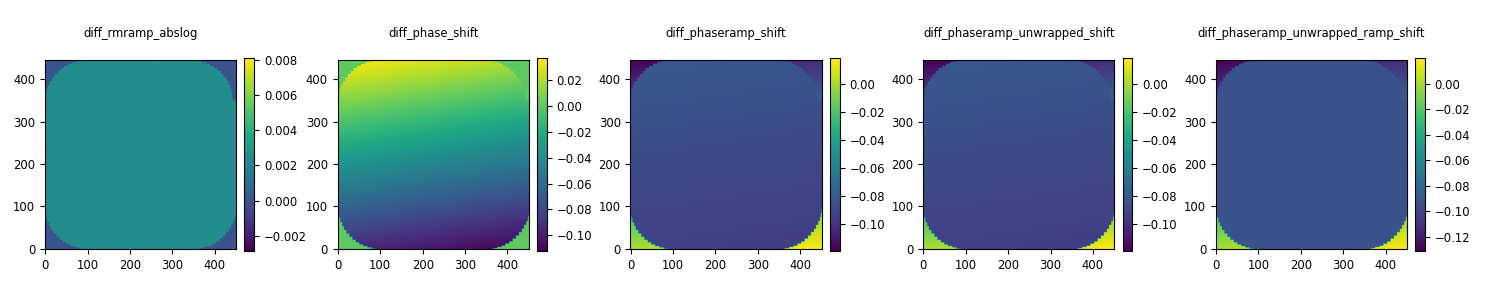

In [9]:
shift_vals = {'0': np.array([-0.010, 0.565]), '1': shift1, '2': np.array([0., 0.210]), '3': np.array([0.020, 0.013]), 
                '4': shift1, '5': shift1, '6': shift1, '7': shift1, '8': np.array([ 0.34, -0.5]), '9': np.array([-0.4,  1.35]),
                '10': np.array([0.039, -0.33])} # array([ 0.34 , -0.157]) # 9: array([-0.009,  2.156])
if scan not in shift_vals.keys(): # make sure there's an shift value for every scan-set.
    shift_vals[scan] = shift1
    print(f"{''.center(80, '-')}\n{''.center(80, '-')}\n", f"UPDATE NEW ENTRANCE IN shift_vals WITH , '{scan}': np.array({[shift1[0], shift1[1]]})\n", f"{''.center(80, '-')}\n{''.center(80, '-')}\n")

shift_val = shift_vals[scan]

###############--> obj2_abslog_shift = shift(obj2_abslog, shift_val)#, [-0.015,  0.0  ])
obj2_rmramp_abslog_shift = shift(obj2_rmramp_abslog, shift_val)#, [-0.015,  0.0  ])
obj2_phase_shift = shift(obj2_phase, shift_val)#, [-0.015,  0.0  ])
obj2_phaseramp_shift = shift(obj2_phaseramp, shift_val)#, [-0.015,  0.0  ])
obj2_phaseramp_unwrapped_shift = shift(obj2_phaseramp_unwrapped, shift_val)#, [-0.015,  0.0  ])

###############--> diff_rmramp_abslog_shift = obj1_abslog - obj2_abslog_shift # optical density
diff_rmramp_abslog_shift = obj1_rmramp_abslog - obj2_rmramp_abslog_shift # optical density
diff_phase_shift = obj1_phase - obj2_phase_shift
diff_phaseramp_shift = obj1_phaseramp - obj2_phaseramp_shift
diff_phaseramp_unwrapped_shift = obj1_phaseramp_unwrapped - obj2_phaseramp_unwrapped_shift
diff_phaseramp_unwrapped_ramp_shift = np.angle(rmphaseramp(  np.exp(1j*diff_phaseramp_unwrapped_shift), rampweight(np.exp(1j*diff_phaseramp_unwrapped_shift), scale=3)  ))

fig3, axs = plt.subplots(nrows=1, ncols=5, figsize=(3 * 5, 3))
fig3.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
subfig5 = axs[0].imshow(diff_rmramp_abslog_shift, origin='lower')#norm=mpl.colors.LogNorm(vmin=2.27e-02))
subfig6 = axs[1].imshow(angle_trunc(diff_phase_shift), origin='lower')
subfig7 = axs[2].imshow(angle_trunc(diff_phaseramp_shift), origin='lower')
subfig8 = axs[3].imshow(angle_trunc(diff_phaseramp_unwrapped_shift), origin='lower')
subfig9 = axs[4].imshow(angle_trunc(diff_phaseramp_unwrapped_ramp_shift), origin='lower')
plt.colorbar(subfig5, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig6, ax=axs[1], fraction=0.046, pad=0.04)
plt.colorbar(subfig7, ax=axs[2], fraction=0.046, pad=0.04)
plt.colorbar(subfig8, ax=axs[3], fraction=0.046, pad=0.04)
plt.colorbar(subfig9, ax=axs[4], fraction=0.046, pad=0.04)
plt.setp(axs[0], title='diff_rmramp_abslog\n')
plt.setp(axs[1], title='diff_phase_shift\n')
plt.setp(axs[2], title='diff_phaseramp_shift\n')
plt.setp(axs[3], title='diff_phaseramp_unwrapped_shift\n')
plt.setp(axs[4], title='diff_phaseramp_unwrapped_ramp_shift\n')

sliders = []
for val, subfig in enumerate([subfig5, subfig6, subfig7, subfig8, subfig9]):
    slider, arr, subfig = add_slider(subfig.get_array().data, subfig, init_slider_value=slider_values[scan][val])
    sliders.append((slider, arr, subfig))
    slider.observe(update, names='value')

ui2 = widgets.HBox([slider for slider, _, _ in sliders])
display(ui2)
plt.show()

In [10]:
if savefigs == True:
    fig3.savefig(fname2.rsplit('/', 2)[0] + f'/offlinelivediff{samplename[scan]}.png')

<h3>True reference diff</h3>

In [11]:
# Load GT data.
"""
If the reconstructions are made on simulated data, compare the difference between the original probe and object.
"""
pr = None

if int(scan) in list(range(0,9)):
    print(scan,'no GT')
    fname3 = None
elif int(scan) in list(range(9,15)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/NTT_scan_001190/original_recon/NTT_1190_startframe2912_crop1024_dist367_defocus980_a0.8_00/dumps/dump_scan_000000_DM_pycuda_1000.ptyr'
elif int(scan) in list(range(15,20)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/NTT_scan_001190/original_recon/NTT_1190_startframe2912_crop256_dist367_defocus980_a0.8_00/dumps/dump_scan_000000_DM_pycuda_1000.ptyr'
elif int(scan) in list(range(20,27)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/41566_2016_Article_BFnphoton2015279_Fig1_HTML.png'
elif int(scan) in list(range(27,29)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/Diamond/simulated_data/Diam_01/data/data_scan_000000.ptyd'#"/home/reblex/Documents/Diamond-Workshop-2023/small_data/painting.jpg"
elif int(scan) in list(range(29,50)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/siemens_array.npy'
    fname_pr = glob.glob(fname1.rsplit('/',2)[0] + '/data/*.ptyd')[0]
    pr = io.h5read(fname_pr, 'info/illumination/model')['info/illumination/model']
elif int(scan) in list(range(50,51)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/siemens_array.npy'
    fname_pr = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_data/simg_64px_Au-Si3N4_gauss_step10px_r40_1e+12_01/data/data_scan_000000.ptyd'
    pr = io.h5read(fname_pr, 'info/illumination/model')['info/illumination/model']
elif int(scan) in list(range(51,70)):
    fname3 = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/siemens_array.npy'
    fname_pr = '/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_data/simg_256px_Au-Si3N4_step10px_1e+12_00/data/data_scan_000000.ptyd'
    pr = io.h5read(fname_pr, 'info/illumination/model')['info/illumination/model']

if fname3 is not None:
    if fname3.endswith('.ptyr'):
        obj = io.h5read(fname3, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0]
        pr = io.h5read(fname3, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'][0]
    elif fname3.endswith('.ptyd'):
        obj = io.h5read(fname3, 'info/sample/model')['info/sample/model']
        fname_pr = '/data/staff/nanomax/reblex/data-simulated-recons/Diamond/dls_i08_nanogold_recon.ptyr'
        pr = io.h5read(fname_pr, 'content/probe/Sscan_00G00/data')['content/probe/Sscan_00G00/data'][0]
    elif fname3.endswith('.npy'):
        obj = np.load(fname3)
        #fname_pr = "/data/staff/nanomax/reblex/data-simulated-recons/NTT_scan_001190/original_recon/NTT_1190_startframe2912_crop256_dist367_defocus980_a0.8_00/dumps/dump_scan_000000_DM_pycuda_1000.ptyr"
        if pr is None:
            pr = io.h5read(fname_pr, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'][0]
    else:
        from PIL import Image
        obj_arr = u.rgb2complex(np.array(Image.open(fname3)))
        obj = obj_arr*1e0
    obj_abs = np.abs(obj)
    obj_abslog = np.log(obj_abs)
    obj_phase = np.angle(obj)
    w = rampweight(obj, scale=100)
    obj_ramp, ramp = rmphaseramp(obj, w, return_phaseramp=True)
    obj_rmramp_abs = np.abs(obj_ramp)
    obj_rmramp_abslog = np.log(np.abs(obj_ramp))
    obj_phaseramp = np.angle(obj_ramp)
    obj_phaseramp_unwrapped = unwrap_phase(obj_phaseramp)


In [12]:
# Compare GT data with recons from simulations with DIFFERENT POSITIONS.

sh = obj_abs.shape
sh1 = obj1_abs.shape

if sh != sh1:
    # Also assuming that obj1_abs.shape == obj2_abs.shape here!
    
    padrow = (sh[0]-sh1[0])//2
    padcol = (sh[1]-sh1[1])//2
    # obj1_abs_pad = np.zeros(sh)    # old padding solution
    # obj1_abs_pad[ padrow:padrow+sh1[0], padcol:padcol+sh1[1] ] = obj1_abs    # old padding solution
    
    obj1_pad = np.pad(obj1, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_abs_pad = np.pad(obj1_abs, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_abslog_pad = np.pad(obj1_abslog, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_phase_pad = np.pad(obj1_phase, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_ramp_pad = np.pad(obj1_ramp, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_rmramp_abs_pad = np.pad(obj1_rmramp_abs, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_rmramp_abslog_pad = np.pad(obj1_rmramp_abslog, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_phaseramp_pad = np.pad(obj1_phaseramp, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    #obj1_phaseramp_pad = np.pad(obj1_phaseramp-(np.mean(obj1_phaseramp) -np.mean(obj_phaseramp)), ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj1_phaseramp_unwrapped_pad = np.pad(obj1_phaseramp_unwrapped, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))

    obj2_pad = np.pad(obj2, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_abs_pad = np.pad(obj2_abs, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_abslog_pad = np.pad(obj2_abslog, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_phase_pad = np.pad(obj2_phase, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_ramp_pad = np.pad(obj2_ramp, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_rmramp_abs_pad = np.pad(obj2_rmramp_abs, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_rmramp_abslog_pad = np.pad(obj2_rmramp_abslog, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_phaseramp_pad = np.pad(obj2_phaseramp, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    #obj2_phaseramp_pad = np.pad(obj2_phaseramp-(np.mean(obj2_phaseramp) -np.mean(obj_phaseramp)), ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    obj2_phaseramp_unwrapped_pad = np.pad(obj2_phaseramp_unwrapped, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
    
    marg = 220
    shift2offline, error, phasediff = phase_cross_correlation(obj_ramp[marg:-marg,marg:-marg], obj1_ramp_pad[marg:-marg,marg:-marg], upsample_factor=100)
    

    print(sh, sh1, obj1_phaseramp_unwrapped_pad.shape, shift2offline)

(1341, 1341) (446, 451) (1341, 1341) [0. 0.]


In [13]:
sh != sh1

True

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 UPDATE NEW ENTRANCE IN shift_vals WITH 
shift_vals1	, '54': np.array([0.0, 0.0])
shift_vals2	, '54': np.array([0.0, 0.0])
 --------------------------------------------------------------------------------
--------------------------------------------------------------------------------



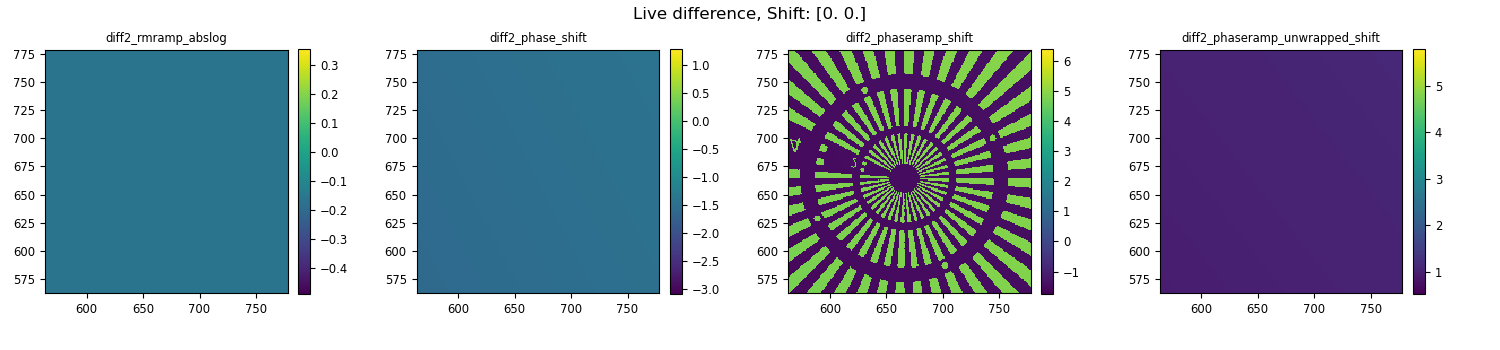

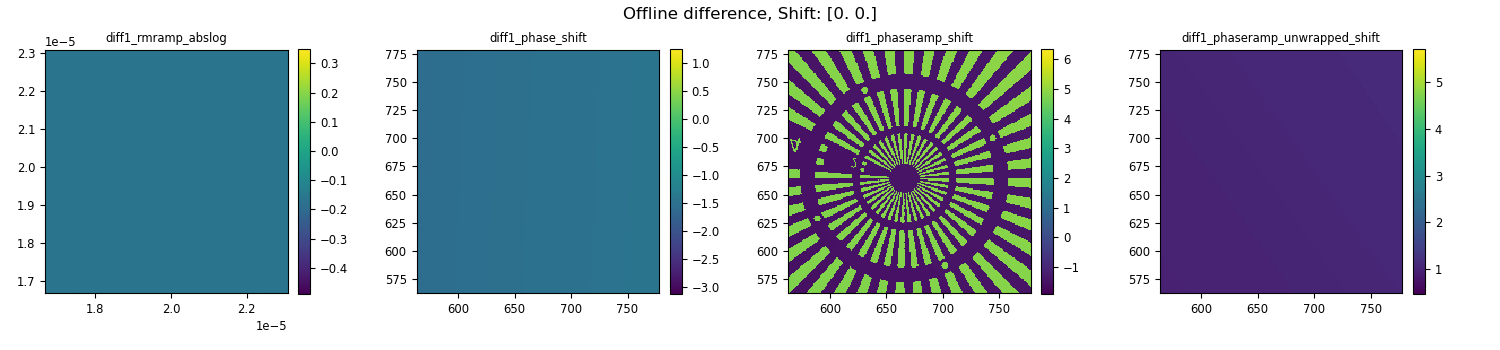

In [14]:
# Compare GT data with recons.


marg = ((min(sh) - max(sh1)) // 2) + int(max(sh1) // 3.8)

if sh != sh1:
    # Then we should use padded data obtained in the cell above!
    obj1_abs_ = obj1_abs_pad - np.mean(obj1_abs_pad[marg:-marg, marg:-marg])
    obj1_abslog_ = obj1_abslog_pad - np.mean(obj1_abslog_pad[marg:-marg, marg:-marg])
    obj1_phase_ = obj1_phase_pad - np.mean(obj1_phase_pad[marg:-marg, marg:-marg])
    obj1_ramp_ = obj1_ramp_pad - np.mean(obj1_ramp_pad[marg:-marg, marg:-marg])
    obj1_rmramp_abs_ = obj1_rmramp_abs_pad - np.mean(obj1_rmramp_abs_pad[marg:-marg, marg:-marg])
    obj1_rmramp_abslog_ = obj1_rmramp_abslog_pad - np.mean(obj1_rmramp_abslog_pad[marg:-marg, marg:-marg])
    obj1_phaseramp_ = obj1_phaseramp_pad - np.mean(obj1_phaseramp_pad[marg:-marg, marg:-marg])
    obj1_phaseramp_unwrapped_ = obj1_phaseramp_unwrapped_pad - np.mean(obj1_phaseramp_unwrapped_pad[marg:-marg, marg:-marg])

    obj2_abs_ = obj2_abs_pad - np.mean(obj2_abs_pad[marg:-marg, marg:-marg])
    obj2_abslog_ = obj2_abslog_pad - np.mean(obj2_abslog_pad[marg:-marg, marg:-marg])
    obj2_phase_ = obj2_phase_pad - np.mean(obj2_phase_pad[marg:-marg, marg:-marg])
    obj2_ramp_ = obj2_ramp_pad - np.mean(obj2_ramp_pad[marg:-marg, marg:-marg])
    obj2_rmramp_abs_ = obj2_rmramp_abs_pad - np.mean(obj2_rmramp_abs_pad[marg:-marg, marg:-marg])
    obj2_rmramp_abslog_ = obj2_rmramp_abslog_pad - np.mean(obj2_rmramp_abslog_pad[marg:-marg, marg:-marg])
    obj2_phaseramp_ = obj2_phaseramp_pad - np.mean(obj2_phaseramp_pad[marg:-marg, marg:-marg])
    obj2_phaseramp_unwrapped_ = obj2_phaseramp_unwrapped_pad - np.mean(obj2_phaseramp_unwrapped_pad[marg:-marg, marg:-marg])

obj_abs_ = obj_abs
obj_abslog_ = obj_abslog
obj_phase_ = obj_phase
obj_ramp_ = obj_ramp
obj_rmramp_abs_ = obj_rmramp_abs
obj_rmramp_abslog_ = obj_rmramp_abslog
obj_phaseramp_ = obj_phaseramp
obj_phaseramp_unwrapped_ = obj_phaseramp_unwrapped


shift2offline, error, phasediff1 = phase_cross_correlation(obj_ramp_, obj1_ramp_, upsample_factor=100)
shift2live, error, phasediff2 = phase_cross_correlation(obj_ramp_, obj2_ramp_, upsample_factor=100)

# best manual shifts: 15offline: np.array([2.038, -2.029])   - region differences
# 15live: np.array([2.037, -2.12]) - region differences
# 16live: np.array([1.34, -2.10])  - region differences
# 17live: np.array([2.02, -2.08])  - region differences
# 18live: np.array([1.77, -1.46])  - region differences

shift_vals1 = {'9': np.array([7.49, -8.5]), '10': np.array([4.00, -3.5]), '15': np.array([2.038, -2.029]), '16': np.array([2.038, -2.029]), '17': np.array([2.038, -2.029]), '18': np.array([2.038, -2.029])}  # 15: 2.013, -1.997
shift_vals2 = {'9':  np.array([7.776, -7.143]), '10': np.array([4.073, -3.982]), '15': np.array([2.037, -2.12]), '16': np.array([1.34, -2.10]), '17': np.array([2.02, -2.08]),
               '18': np.array([1.77, -1.46])}  # 2.013, -1.997, best by trial n err with angle_trunc: 1.995, -1.975
if scan not in shift_vals1.keys():  # make sure there's an shift value for every scan-set.
    shift_vals1[scan] = shift2offline
    shift_vals2[scan] = shift2live
    print(f"{''.center(80, '-')}\n{''.center(80, '-')}\n",
          f"UPDATE NEW ENTRANCE IN shift_vals WITH \nshift_vals1\t, '{scan}': np.array({[shift2offline[0], shift2offline[1]]})\nshift_vals2\t, '{scan}': np.array({[shift2live[0], shift2live[1]]})\n",
          f"{''.center(80, '-')}\n{''.center(80, '-')}\n")
else:
    shift2offline = shift_vals1[scan]
    shift2live = shift_vals2[scan]

if obj_rmramp_abslog_.shape != obj1_rmramp_abslog_.shape:
    print('Reconstructions have different shapes! Rebinning is made in order to calculate the difference, this might cause changes along the edges of the sample!')
    # Difference in offline recon
    diff1_rmramp_abslog_od = u.rebin_2d(obj_rmramp_abslog_[:3724, :3724], 2)[0] - obj1_rmramp_abslog_[:, :1862]  # optical density
    diff1_phase = u.rebin_2d(obj_phase_[:3724, :3724], 2)[0] - obj1_phase_[:, :1862]
    diff1_phaseramp = u.rebin_2d(obj_phaseramp_[:3724, :3724], 2)[0] - obj1_phaseramp_[:, :1862]
    diff1_phaseramp_unwrapped = u.rebin_2d(obj_phaseramp_unwrapped_[:3724, :3724], 2)[0] - obj1_phaseramp_unwrapped_[:, :1862]
    diff1_pr_phase = np.abs(u.rebin_2d(pr, 2)[0]) - np.abs(pr1)

    shift_offline = np.array([4.00, -3.5])  # 4.026, -3.672# 4.023, -3.611# 4.023, -3.5#4.00, -3.5 # 4.039, -3.673
    diff1_rmramp_abslog_od = u.rebin_2d(obj_rmramp_abslog_[:3724, :3724], 2)[0] - shift(obj1_rmramp_abslog_[:, :1862], shift_offline)
    diff1_phase = u.rebin_2d(obj_phase_[:3724, :3724], 2)[0] - shift(obj1_phase_[:, :1862], shift_offline)
    diff1_phaseramp = u.rebin_2d(obj_phaseramp_[:3724, :3724], 2)[0] - shift(obj1_phaseramp_[:, :1862], shift_offline)
    diff1_phaseramp_unwrapped = u.rebin_2d(obj_phaseramp_unwrapped_[:3724, :3724], 2)[0] - shift(obj1_phaseramp_unwrapped_[:, :1862], shift_offline)

    # Difference in live recon
    diff2_rmramp_abslog_od = u.rebin_2d(obj_rmramp_abslog_[:3724, :3724], 2)[0] - obj2_rmramp_abslog_[:, :1862]  # optical density
    diff2_phase = u.rebin_2d(obj_phase_[:3724, :3724], 2)[0] - obj2_phase_[:, :1862]
    diff2_phaseramp = u.rebin_2d(obj_phaseramp_[:3724, :3724], 2)[0] - obj2_phaseramp_[:, :1862]
    diff2_phaseramp_unwrapped = u.rebin_2d(obj_phaseramp_unwrapped_[:3724, :3724], 2)[0] - obj2_phaseramp_unwrapped_[:, :1862]
    diff2_pr_phase = np.abs(u.rebin_2d(pr, 2)[0]) - np.abs(pr2)

    shift_live = np.array([4.073, -3.982])  # 1.875, -4.835 # 4.0, -4.335
    diff2_rmramp_abslog_od = u.rebin_2d(obj_rmramp_abslog_[:3724, :3724], 2)[0] - shift(obj2_rmramp_abslog_[:, :1862], shift_live)
    diff2_phase = u.rebin_2d(obj_phase_[:3724, :3724], 2)[0] - shift(obj2_phase_[:, :1862], shift_live)
    diff2_phaseramp = u.rebin_2d(obj_phaseramp_[:3724, :3724], 2)[0] - shift(obj2_phaseramp_[:, :1862], shift_live)
    diff2_phaseramp_unwrapped = u.rebin_2d(obj_phaseramp_unwrapped_[:3724, :3724], 2)[0] - shift(obj2_phaseramp_unwrapped_[:, :1862], shift_live)
else:
    # # Difference in offline recon
    diff1_rmramp_abslog_od = obj_rmramp_abslog_ - shift(obj1_rmramp_abslog_, shift2offline) # optical density
    diff1_phase = obj_phase_ - shift(obj1_phase_, shift2offline)
    diff1_phaseramp = obj_phaseramp_ - shift(obj1_phaseramp_, shift2offline)
    diff1_phaseramp_unwrapped = obj_phaseramp_unwrapped_ - shift(obj1_phaseramp_unwrapped_, shift2offline)
    diff1_pr_abs = np.log(np.abs(pr)) - np.log(np.abs(pr1))
    diff1_pr_phase = np.angle(pr) - np.angle(pr1)
    diff1_phase[diff1_phase < np.pi] += 2*np.pi
    diff1_phase[diff1_phase > np.pi] -= 2*np.pi

    # Difference in live recon
    diff2_rmramp_abslog_od = obj_rmramp_abslog_ - shift(obj2_rmramp_abslog_, shift2live)  # optical density
    diff2_phase = obj_phase_ - shift(obj2_phase_, shift2live)
    diff2_phaseramp = obj_phaseramp_ - shift(obj2_phaseramp_, shift2live)
    diff2_phaseramp_unwrapped = obj_phaseramp_unwrapped_ - shift(obj2_phaseramp_unwrapped_, shift2live)
    diff2_pr_abs = np.abs(pr) - np.abs(pr2)
    diff2_pr_phase = np.angle(pr) - np.angle(pr2)
    diff2_phase[diff2_phase < np.pi] += 2*np.pi
    diff2_phase[diff2_phase > np.pi] -= 2*np.pi

fig4, axs = plt.subplots(nrows=1, ncols=4, figsize=(3 * 5, 3.5))
fig4.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.95, wspace=0.40, hspace=0.2)
##subfig10 = axs[0].imshow(diff1_rmramp_abslog_od, origin='lower', interpolation='None')#norm=mpl.colors.LogNorm(vmin=2.27e-02))
x1 = np.arange(0, (sh[1] + 1) * obj1_psize, obj1_psize)
y1 = np.arange(0, (sh[0] + 1) * obj1_psize, obj1_psize)
X, Y = np.meshgrid(x1, y1)
subfig10 = axs[0].pcolormesh(X, Y, diff1_rmramp_abslog_od)  # , origin='lower', interpolation='None')
axs[0].set_box_aspect(sh[0] / sh[1])
subfig11 = axs[1].imshow((diff1_phase), origin='lower', interpolation='None')
subfig12 = axs[2].imshow((diff1_phaseramp), origin='lower', interpolation='None')
subfig13 = axs[3].imshow((diff1_phaseramp_unwrapped), origin='lower', interpolation='None')
plt.colorbar(subfig10, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig11, ax=axs[1], fraction=0.046, pad=0.04)
plt.colorbar(subfig12, ax=axs[2], fraction=0.046, pad=0.04)
plt.colorbar(subfig13, ax=axs[3], fraction=0.046, pad=0.04)
plt.setp(axs[0], title='diff1_rmramp_abslog')
plt.setp(axs[1], title='diff1_phase_shift')
plt.setp(axs[2], title='diff1_phaseramp_shift')
plt.setp(axs[3], title='diff1_phaseramp_unwrapped_shift')
fig4.suptitle(f'Offline difference, Shift: {shift2offline}')

fig5, axs = plt.subplots(nrows=1, ncols=4, figsize=(3 * 5, 3.5))
fig5.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.95, wspace=0.40, hspace=0.2)
subfig14 = axs[0].imshow(diff2_rmramp_abslog_od, origin='lower', interpolation='None')  # norm=mpl.colors.LogNorm(vmin=2.27e-02))
subfig15 = axs[1].imshow((diff2_phase), origin='lower', interpolation='None')
subfig16 = axs[2].imshow((diff2_phaseramp), origin='lower', interpolation='None')
subfig17 = axs[3].imshow((diff2_phaseramp_unwrapped), origin='lower', interpolation='None')
plt.colorbar(subfig14, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig15, ax=axs[1], fraction=0.046, pad=0.04)
plt.colorbar(subfig16, ax=axs[2], fraction=0.046, pad=0.04)
plt.colorbar(subfig17, ax=axs[3], fraction=0.046, pad=0.04)
plt.setp(axs[0], title='diff2_rmramp_abslog')
plt.setp(axs[1], title='diff2_phase_shift')
plt.setp(axs[2], title='diff2_phaseramp_shift')
plt.setp(axs[3], title='diff2_phaseramp_unwrapped_shift')
fig5.suptitle(f'Live difference, Shift: {shift2live}')


slider_values = {'9':  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '10': [1.0, 1.0, 0.3, 1.0, 1.0, 1.0, 0.3, 1.0], '11': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '12': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                 '13': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '14': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '15': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 0.2, 1.8], '16': [1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 2.0],
                 '17': [1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 0.25, 1.7], '18': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 1.0, 1.8], '19': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 0.2, 1.8], '20': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 0.2, 1.8],
                 '29': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 0.2, 1.8], '30': [1.0, 1.0, 0.2, 1.8, 1.0, 1.0, 0.2, 1.8]}
if scan not in slider_values.keys():  # make sure there's an shift value for every scan-set.
    slider_values[scan] = slider_values['30']

sliders = []
for val, subfig in enumerate([subfig10, subfig11, subfig12, subfig13, subfig14, subfig15, subfig16, subfig17]):  # subfig10, subfig11, subfig12, subfig13, subfig14, subfig15, subfig16, subfig17
    slider, arr, subfig = add_slider(subfig.get_array().data, subfig, init_slider_value=slider_values[scan][val])
    sliders.append((slider, arr, subfig))
    slider.observe(update, names='value')

ui3 = widgets.HBox([slider for slider, _, _ in sliders])
display(ui3)

subfig10.axes.set_ylim(y1[marg], y1[-marg])
subfig10.axes.set_xlim(x1[marg], x1[-marg])

# subfig10.axes.set_ylim(marg, sh[0]-marg)
# subfig10.axes.set_xlim(marg, sh[1]-marg)
subfig11.axes.set_ylim(marg, sh[0] - marg)
subfig11.axes.set_xlim(marg, sh[1] - marg)
subfig12.axes.set_ylim(marg, sh[0] - marg)
subfig12.axes.set_xlim(marg, sh[1] - marg)
subfig13.axes.set_ylim(marg, sh[0] - marg)
subfig13.axes.set_xlim(marg, sh[1] - marg)
subfig14.axes.set_ylim(marg, sh[0] - marg)
subfig14.axes.set_xlim(marg, sh[1] - marg)
subfig15.axes.set_ylim(marg, sh[0] - marg)
subfig15.axes.set_xlim(marg, sh[1] - marg)
subfig16.axes.set_ylim(marg, sh[0] - marg)
subfig16.axes.set_xlim(marg, sh[1] - marg)
subfig17.axes.set_ylim(marg, sh[0] - marg)
subfig17.axes.set_xlim(marg, sh[1] - marg)
plt.show()

In [15]:
print(np.min(diff2_rmramp_abslog_od), np.max(diff2_rmramp_abslog_od))
subfig14.get_clim()

-0.48927174604739443 0.35380074850571674


(-0.48927174604739443, 0.35380074850571674)

In [16]:
# Save figures
# fig4.savefig(fname1.rsplit('/', 2)[0] + '/GT_diff1_shift-obj_ramp.eps')
# lables = {'15': '_fpb50', '16': '_fpb20', '17': '_fpb300', '18': '_flip'}
# lable = lables[scan] if scan in lables.keys() else ''
# fig5.savefig(fname2.rsplit('/', 2)[0] + f'/GT_diff2{lable}_shift-obj_ramp.eps')
if savefigs == True:
    fig4.savefig(fname1.rsplit('/', 2)[0] + f'/GT_diff1{samplename[scan]}.png')
    lables = {'15': '_fpb50', '16': '_fpb20', '17': '_fpb300', '18': '_flip'}
    lable = lables[scan] if scan in lables.keys() else ''
    fig5.savefig(fname2.rsplit('/', 2)[0] + f'/GT_diff2{lable}.png')

<h4>Translation shift sliders</h4>

501


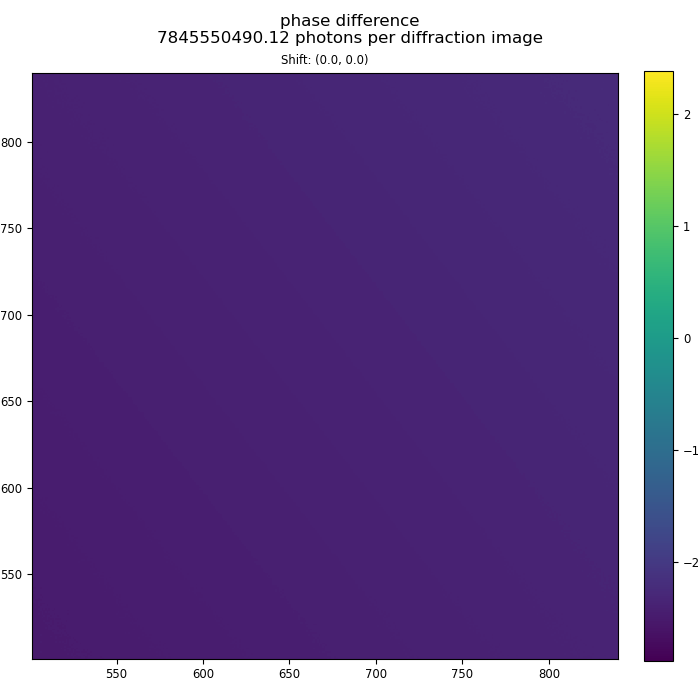

In [17]:
# Plot with shift sliders
marg= ((min(sh)-max(sh1))//2) + int(max(sh1)//8)

obj_phaseramp_ = obj_phaseramp#ramp_unwrapped#obj_abs
obj1_phaseramp_ = obj2_phaseramp_pad#ramp_unwrapped_pad#obj1_abs#obj1_phaseramp_unwrapped
whatdata = 'phase'#ramp_unwrapped' # 'phaseramp'
obj_phaseramp_ = obj_phaseramp_ - np.mean(obj_phaseramp_[marg:-marg, marg:-marg])
obj1_phaseramp_ = obj1_phaseramp_ - np.mean(obj1_phaseramp_[marg:-marg, marg:-marg])

# Initialize shift values
shift1_x = shift2offline[0]#0.04    # testing offline
shift1_y = shift2offline[1]#-0.01   # 'testing offline 


# Compute the shifted image
diff1_phaseramp_ = (shift(obj_phaseramp_, [-shift1_x/2, -shift1_y/2]) - shift(obj1_phaseramp_, [shift1_x/2, shift1_y/2])) #/ shift(obj_phaseramp_, [-shift1_x/2, -shift1_y/2])
#diff1_phaseramp_[diff1_phaseramp_ < 0] += 2*np.pi
#diff1_phaseramp_[diff1_phaseramp_ > 0] -= 2*np.pi

# diff1_phaseramp_[diff1_phaseramp_ < 2*np.pi] += 4*np.pi
# diff1_phaseramp_[diff1_phaseramp_ > 2*np.pi] -= 4*np.pi
diff1_phaseramp_[diff1_phaseramp_ < np.pi] += 2*np.pi
diff1_phaseramp_[diff1_phaseramp_ > np.pi] -= 2*np.pi
# Create figure and axes
fig8, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7), tight_layout={'pad': 0.0})
subfigX = axs.imshow(diff1_phaseramp_, origin='lower', interpolation='None')
plt.colorbar(subfigX, ax=axs, fraction=0.046, pad=0.04)
plt.setp(axs, title=f'Shift: ({shift1_x}, {shift1_y})')
fig8.suptitle(f'{whatdata} difference\n{mean_photons1} photons per diffraction image')

z=100
M, N = obj.shape
# subfigX.axes.set_xlim(M//2 - z, M//2 + z)
# subfigX.axes.set_ylim(N//2 - z, N//2 + z)


# Function to update the plot when sliders are moved
def update_plot(change):
    # Update shift values from slider values
    shift1_x = x_slider.value
    shift1_y = y_slider.value
    
    # Compute the shifted image
    diff1_phaseramp_ = (shift(obj_phaseramp_, [-shift1_x/2, -shift1_y/2]) - shift(obj1_phaseramp_, [shift1_x/2, shift1_y/2])) #/ shift(obj_phaseramp_, [-shift1_x/2, -shift1_y/2])
    diff1_phaseramp_[diff1_phaseramp_ < np.pi] += 2*np.pi
    diff1_phaseramp_[diff1_phaseramp_ > np.pi] -= 2*np.pi
    
    # Update image data
    subfigX.set_data(diff1_phaseramp_)
    
    # Update title with new shift values
    plt.setp(axs, title=f'Shift: ({shift1_x}, {shift1_y})')

# Create FloatSlider widgets for x and y shifts
x_slider = widgets.FloatSlider(value=shift1_x, min=shift1_x-0.9, max=shift1_x+0.9, step=0.01, description='shift1_x', layout=widgets.Layout(width='90%'), readout_format='.3f')
y_slider = widgets.FloatSlider(value=shift1_y, min=shift1_y-0.9, max=shift1_y+0.9, step=0.01, description='shift1_y', layout=widgets.Layout(width='90%'), readout_format='.3f')

# Observe slider changes and call update_plot function
x_slider.observe(update_plot, names='value')
y_slider.observe(update_plot, names='value')

# Display the sliders
display(widgets.VBox([x_slider, y_slider]))
#marg= ((min(sh)-max(sh1))//2) +(max(sh1)//4)#460
sliders = []
for val, subfig in enumerate([subfigX]):
    slider, arr, subfig = add_slider(subfig.get_array().data, subfig, init_slider_value=1.8)#slider_values[scan][val])
    sliders.append((slider, arr, subfig))
    slider.observe(update, names='value')

ui3 = widgets.HBox([slider for slider, _, _ in sliders])
display(ui3)

subfigX.axes.set_ylim(marg, sh[0]-marg)
subfigX.axes.set_xlim(marg, sh[1]-marg)#[marg:-marg,marg:-marg]
print(marg)
# z=100
# M, N = obj.shape
# subfigX.axes.set_xlim(M//2 - z, M//2 + z)
# subfigX.axes.set_ylim(N//2 - z, N//2 + z)

In [18]:
if savefigs:
    fig8.savefig(fname2.rsplit('/', 2)[0] + f'/{whatdata}{lable}_shift-manual.png')

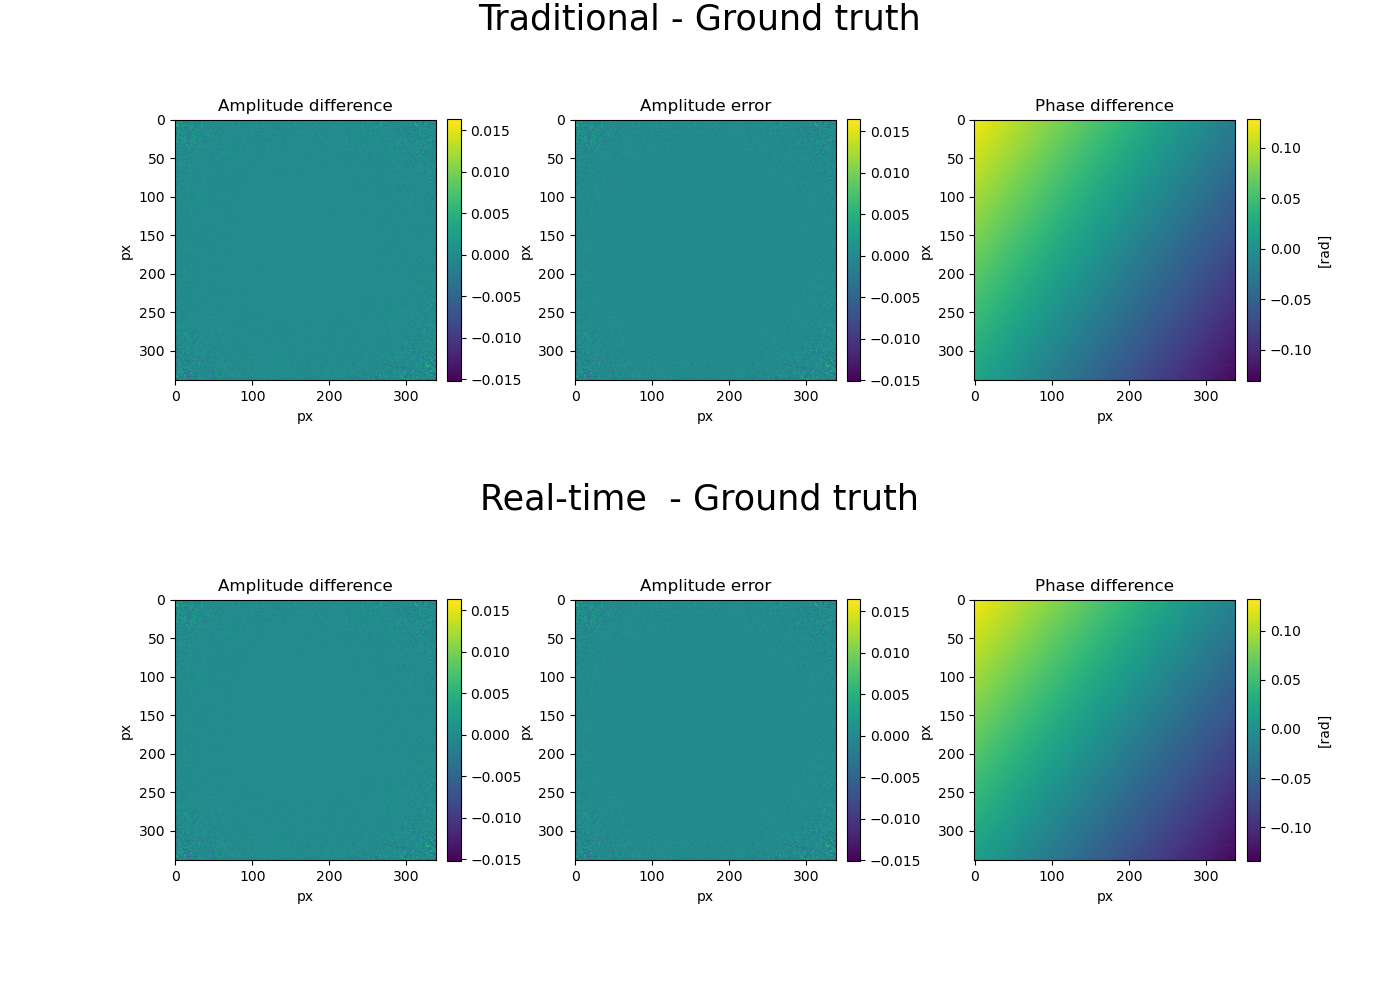

min/max(range) amp1diff, phase_error01: -0.0152 0.0164 (0.0316),  -0.1311 0.1288 (0.2598)
min/max(range) amp2diff, phase_error02: -0.1311 0.1288 (0.2598),  -0.1346 0.1324 (0.2670)
trad, mean amp error:  9.543280161340609e-07
realtime, mean amp error:  9.542236475572768e-07


In [19]:
# Filipes error calculations
#obj1_pad = np.pad(obj1, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
obj1_ = obj1_ramp_pad[marg:-marg,marg:-marg].copy()
#obj2_pad = np.pad(obj2, ((padrow,sh[0]-padrow-sh1[0]),(padcol,sh[1]-padcol-sh1[1])))
obj2_ = obj2_ramp_pad[marg:-marg,marg:-marg].copy()
obj_GT = obj_ramp[marg:-marg,marg:-marg].copy()

from skimage.registration import phase_cross_correlation
shift01,err1_,phase_shift01 = phase_cross_correlation(obj_GT, obj1_)
shift02,err2_,phase_shift02 = phase_cross_correlation(obj_GT, obj2_)

# Uncomment for larger fontsizes
# params = {'legend.fontsize': 20,
#          'axes.labelsize': 25.2,
#          'axes.titlesize': 25.2,
#          'xtick.labelsize':20,
#          'ytick.labelsize': 20}
# plt.rcParams.update(params)
plt.rcdefaults()

# plt.imshow(np.abs(probe))
# plt.show()
# plt.imshow(np.abs(obj1_))
# plt.show()

# Scale the reconstruction to the solution
obj1_ *= np.mean(np.abs(obj_GT)/np.abs(obj1_))
obj2_ *= np.mean(np.abs(obj_GT)/np.abs(obj2_))


# plt.figure()
# plt.imshow(np.log(np.abs(obj1_))-np.log(np.abs(obj_GT)))#,vmin=-1,vmax=1)
# plt.title('log-abs difference')
# plt.colorbar()
# plt.show()

# plt.figure()
phase_error01 = np.angle(obj1_*np.exp(1.0j*phase_shift01))-np.angle(obj_GT)
phase_error01[phase_error01 < np.pi] += 2*np.pi
phase_error01[phase_error01 > np.pi] -= 2*np.pi
# plt.imshow(phase_error01)#,vmin=-1,vmax=1)
# plt.title('phase difference')
# plt.colorbar()
# plt.show()

phase_error02 = np.angle(obj2_*np.exp(1.0j*phase_shift02))-np.angle(obj_GT)
phase_error02 = np.angle(obj2_)+phase_shift02 -np.angle(obj_GT)
phase_error02[phase_error02 < np.pi] += 2*np.pi
phase_error02[phase_error02 > np.pi] -= 2*np.pi

fig9, axs = plt.subplots(nrows=2, ncols=3, figsize=(4 * 3.5, 4 *2.5))
#fig9.subplots_adjust(left=0.00, bottom=0.07, right=0.95, top=0.95, wspace=0.20, hspace=0.1)
fig9.subplots_adjust(top=0.95,  bottom=0.07, wspace=0.40)
subfig18 = axs[0,0].imshow(np.log(np.abs(obj1_))-np.log(np.abs(obj_GT)))
subfig19 = axs[0,1].imshow(( (np.abs(obj1_))-(np.abs(obj_GT)) )/(np.abs(obj_GT)))
subfig20 = axs[0,2].imshow(phase_error01)
subfig21 = axs[1,0].imshow(np.log(np.abs(obj2_))-np.log(np.abs(obj_GT)))
subfig22 = axs[1,1].imshow(( (np.abs(obj2_))-(np.abs(obj_GT)) )/(np.abs(obj_GT)))
subfig23 = axs[1,2].imshow(phase_error02)
plt.setp(axs[0,0], title='Amplitude difference', xlabel='px', ylabel='px')
plt.setp(axs[0,1], title='Amplitude error', xlabel='px', ylabel='px')
plt.setp(axs[0,2], title='Phase difference', xlabel='px', ylabel='px')
plt.setp(axs[1,0], title='Amplitude difference', xlabel='px', ylabel='px')
plt.setp(axs[1,1], title='Amplitude error', xlabel='px', ylabel='px')
plt.setp(axs[1,2], title='Phase difference', xlabel='px', ylabel='px')
plt.colorbar(subfig18, ax=axs[0,0], fraction=0.046, pad=0.04)
plt.colorbar(subfig19, ax=axs[0,1], fraction=0.046, pad=0.04)
plt.colorbar(subfig20, ax=axs[0,2], fraction=0.046, pad=0.04, label='[rad]')
plt.colorbar(subfig21, ax=axs[1,0], fraction=0.046, pad=0.04)
plt.colorbar(subfig22, ax=axs[1,1], fraction=0.046, pad=0.04)
plt.colorbar(subfig23, ax=axs[1,2], fraction=0.046, pad=0.04, label='[rad]')
plt.figtext(0.5, 0.97, 'Traditional - Ground truth', horizontalalignment='center', fontsize=25.2)
plt.figtext(0.5, 0.49, 'Real-time  - Ground truth', horizontalalignment='center', fontsize=25.2)
plt.show()


print(f'min/max(range) amp1diff, phase_error01: {np.min(subfig18.get_array().data):.4f} {np.max(subfig18.get_array().data):.4f} ({(np.max(subfig18.get_array().data) - np.min(subfig18.get_array().data)):.4f}),  {np.min(phase_error01):.4f} {np.max(phase_error01):.4f} ({(np.max(phase_error01) - np.min(phase_error01)):.4f})')

print(f'min/max(range) amp2diff, phase_error02: {np.min(subfig20.get_array().data):.4f} {np.max(subfig20.get_array().data):.4f} ({(np.max(subfig20.get_array().data) - np.min(subfig20.get_array().data)):.4f}),  {np.min(phase_error02):.4f} {np.max(phase_error02):.4f} ({(np.max(phase_error02) - np.min(phase_error02)):.4f})')
# 48(DM1000): min/max phase_error -0.003119856395642273 0.005158036670763977
# 49(DM5000): min/max phase_error -1.1029624147340655e-06 3.375298547325656e-06
# 49(DM4000): min/max phase_error -1.5797995729371905e-06 3.926641511498019e-06
# 49(DM3000): min/max phase_error -1.1029624147340655e-06 3.0325718398671597e-06
# 49(DM2000): min/max phase_error -8.25551978778094e-06 1.3254768418846652e-05

#fig9.savefig(fname2.rsplit('/', 2)[0] + f'/GT_difference{samplename[scan]}.png', dpi=400)
#plt.rcdefaults()

print('trad, mean amp error: ',np.mean(subfig19.get_array().data))
print('realtime, mean amp error: ',np.mean(subfig22.get_array().data))

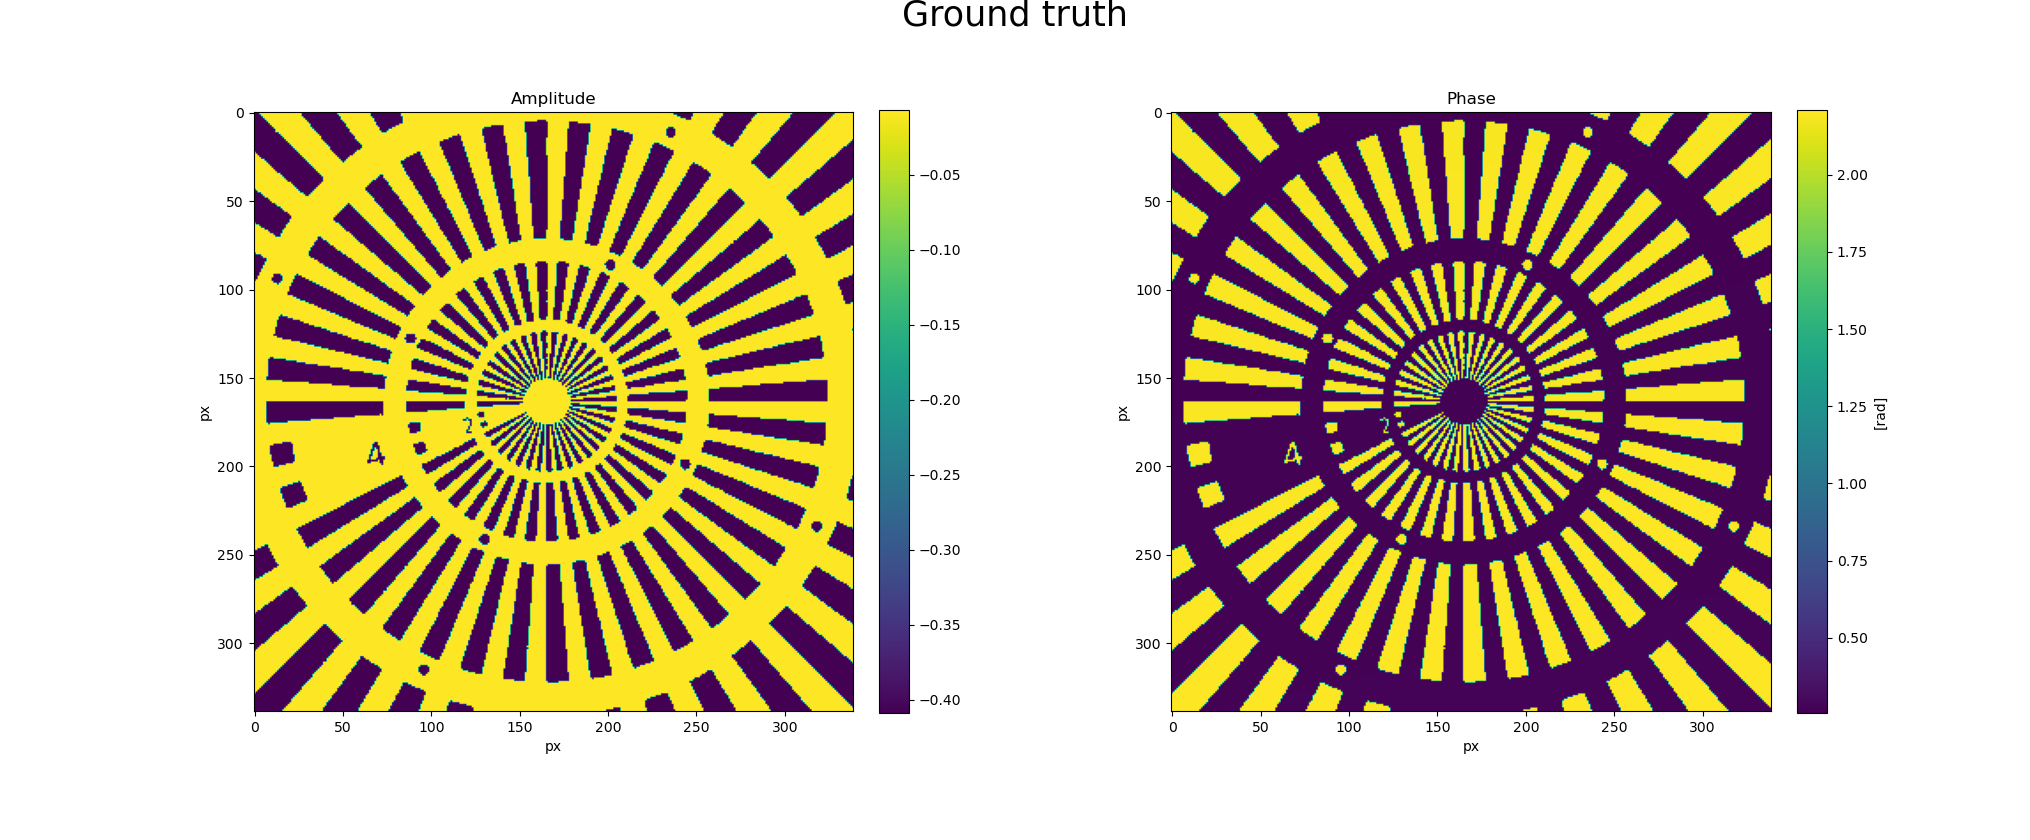

In [20]:
# plot normalized abs, phases
phase_error02[phase_error02 < np.pi] += 2*np.pi
phase_error02[phase_error02 > np.pi] -= 2*np.pi

phase_error02[phase_error02 < 3.14] += 2*3.14
phase_error02[phase_error02 > 3.14] -= 2*3.14

obj1_shifted_phase = np.angle(obj1_)+phase_shift01
obj1_shifted_phase[obj1_shifted_phase < np.pi] += np.pi


# fig10, axs = plt.subplots(nrows=2, ncols=3, figsize=(3*3, 3*2))
# fig10.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.95, wspace=0.40, hspace=0.02)
# subfig22 = axs[0,0].imshow(np.log(np.abs(obj_GT)))
# subfig23 = axs[0,1].imshow(np.log(np.abs(obj1_)))
# subfig24 = axs[0,2].imshow(np.log(np.abs(obj2_)))
# subfig25 = axs[1,0].imshow(np.angle(obj_GT))
# subfig26 = axs[1,1].imshow(obj1_shifted_phase)
# subfig27 = axs[1,2].imshow(np.angle(obj2_)+phase_shift02)
# plt.colorbar(subfig22, ax=axs[0,0], fraction=0.046, pad=0.04)
# plt.colorbar(subfig23, ax=axs[0,1], fraction=0.046, pad=0.04)
# plt.colorbar(subfig24, ax=axs[0,2], fraction=0.046, pad=0.04)
# plt.colorbar(subfig25, ax=axs[1,0], fraction=0.046, pad=0.04)
# plt.colorbar(subfig26, ax=axs[1,1], fraction=0.046, pad=0.04)
# plt.colorbar(subfig27, ax=axs[1,2], fraction=0.046, pad=0.04)

# plt.show()


fig10, axs = plt.subplots(nrows=1, ncols=2, figsize=(7 * 2.9, 7 *1.2))
fig10.subplots_adjust(top=0.95,  bottom=0.07, wspace=0.40)
subfig22 = axs[0].imshow(np.log(np.abs(obj_GT)))
subfig25 = axs[1].imshow(np.angle(obj_GT))
plt.setp(axs[0], title='Amplitude', xlabel='px', ylabel='px')
plt.setp(axs[1], title='Phase', xlabel='px', ylabel='px')
# plt.suptitle('Ground truth', fontsize=25.2)
plt.figtext(0.5, 0.97, 'Ground truth', horizontalalignment='center', fontsize=25.2)
plt.colorbar(subfig22, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig25, ax=axs[1], fraction=0.046, pad=0.04, label='[rad]')
plt.show()
fig10.savefig(fname2.rsplit('/', 2)[0] + f'/GT_{samplename[scan]}.png', dpi=400)


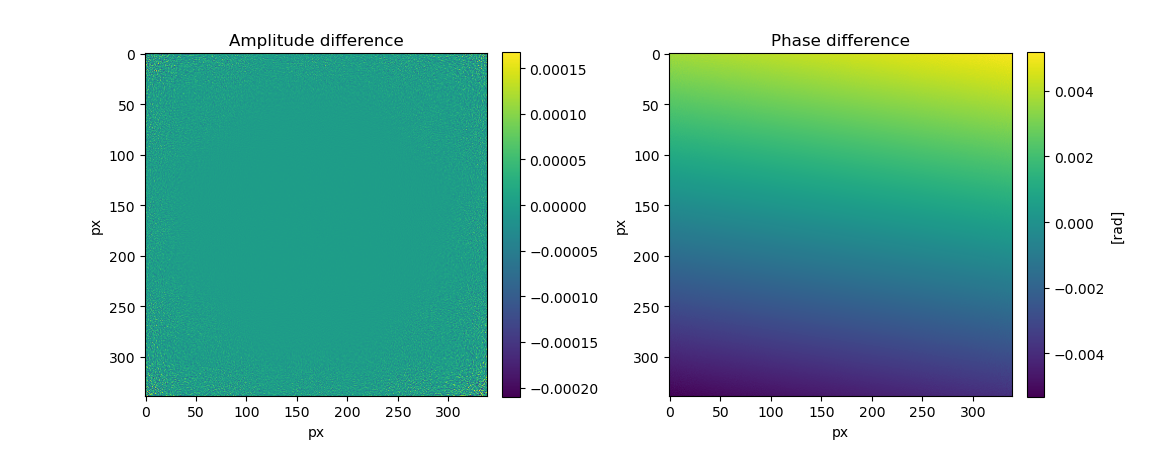

min/max(range) logamp3diff, phase_error03: -0.0002 0.0002 (0.0004),  -0.0053 0.0052 (0.0105)
mean amp error:  3.8680301550194936e-10


In [21]:
# Filipes error calculations but for obj1 vs obj2
obj1_ = obj1_ramp_pad[marg:-marg,marg:-marg]
obj2_ = obj2_ramp_pad[marg:-marg,marg:-marg]

obj2_ *= np.mean(np.abs(obj1_)/np.abs(obj2_))
shift03,_,phase_shift03 = phase_cross_correlation(obj1_, obj2_)
phase_error03 = np.angle(obj2_)+phase_shift03 -np.angle(obj1_)
phase_error03[phase_error03 < np.pi] += 2*np.pi
phase_error03[phase_error03 > np.pi] -= 2*np.pi

fig11, axs = plt.subplots(nrows=1, ncols=2, figsize=(4 * 2.9, 4 *1.15))
#fig11.subplots_adjust(left=0.00, bottom=0.07, right=0.95, top=0.95, wspace=0.20, hspace=0.1)
fig11.subplots_adjust(top=0.95,  bottom=0.07, wspace=0.40)
subfig28 = axs[0].imshow((np.abs(obj2_)) - (np.abs(obj1_)))
subfig29 = axs[1].imshow(phase_error03)
plt.setp(axs[0], title='Amplitude difference', xlabel='px', ylabel='px')
plt.setp(axs[1], title='Phase difference', xlabel='px', ylabel='px')
plt.colorbar(subfig28, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig29, ax=axs[1], fraction=0.046, pad=0.04, label='[rad]')
plt.show()
fig11.savefig(fname2.rsplit('/', 2)[0] + f'/rt-trad_difference{samplename[scan]}.png', dpi=400)

print(f'min/max(range) logamp3diff, phase_error03: {np.min(subfig28.get_array().data):.4f} {np.max(subfig28.get_array().data):.4f} ({(np.max(subfig28.get_array().data) - np.min(subfig28.get_array().data)):.4f}),  {np.min(phase_error03):.4f} {np.max(phase_error03):.4f} ({(np.max(phase_error03) - np.min(phase_error03)):.4f})')
print('mean amp error: ',np.mean( (np.abs(obj2_) - np.abs(obj1_))/np.abs(obj1_) ))

In [22]:
savefigs = True
if savefigs == True:
    fig9.savefig(fname2.rsplit('/', 2)[0] + f'/absphase-difference{samplename[scan]}.png')

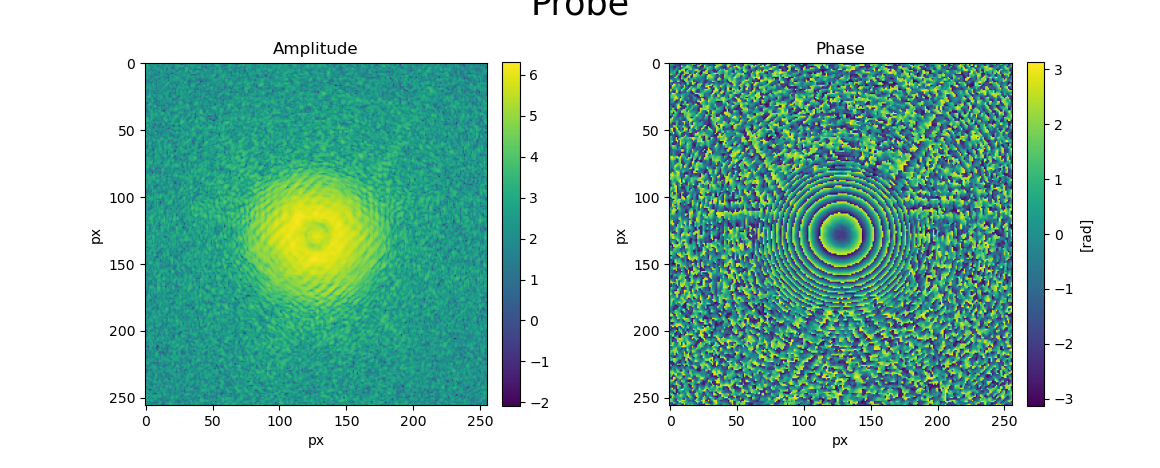

In [23]:
fig12, axs = plt.subplots(nrows=1, ncols=2, figsize=(4 * 2.9, 4 *1.17))
#fig12.subplots_adjust(left=0.00, bottom=0.07, right=0.95, top=0.95, wspace=0.20, hspace=0.1)
fig12.subplots_adjust(top=0.93,  bottom=0.07, wspace=0.40)
subfig28 = axs[0].imshow(np.log(np.abs(pr)))
subfig29 = axs[1].imshow(np.angle(pr))
plt.figtext(0.5, 0.97, 'Probe', horizontalalignment='center', fontsize=25.2)
plt.setp(axs[0], title='Amplitude', xlabel='px', ylabel='px')
plt.setp(axs[1], title='Phase', xlabel='px', ylabel='px')
plt.colorbar(subfig28, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig29, ax=axs[1], fraction=0.046, pad=0.04, label='[rad]')
plt.show()
fig12.savefig(fname2.rsplit('/', 2)[0] + f'/probe{samplename[scan]}.png', dpi=400)

In [24]:
fname2.rsplit('/', 2)[0] + f'/probe{samplename[scan]}.png'

'/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_recons/from_simg_256px_Au-Si3N4_step10px_1e+10_poisTRUE_spiral_00/simg_startframe1____fpb25_GTpr-update_00/probe_spiralstep10px_1e10_GTpr-update.png'

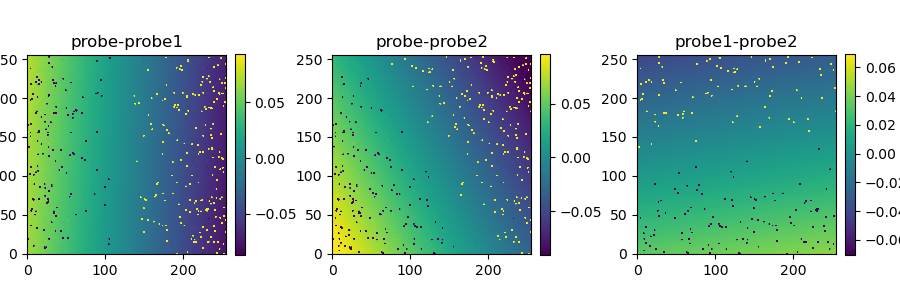

In [25]:
#Probe difference
fig5, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 3, 3))
fig5.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
subfig22 = axs[0].imshow(np.angle(pr) - np.angle(pr1), origin='lower')#norm=mpl.colors.LogNorm(vmin=2.27e-02))
subfig23 = axs[1].imshow(np.angle(pr) - np.angle(pr2), origin='lower')
subfig24 = axs[2].imshow((np.angle(pr1) - np.angle(pr2)), origin='lower')
plt.colorbar(subfig22, ax=axs[0], fraction=0.046, pad=0.04)
plt.colorbar(subfig23, ax=axs[1], fraction=0.046, pad=0.04)
plt.colorbar(subfig24, ax=axs[2], fraction=0.046, pad=0.04)
plt.setp(axs[0], title='probe-probe1')
plt.setp(axs[1], title='probe-probe2')
plt.setp(axs[2], title='probe1-probe2')
marg=1
subfig22.set_clim(set_vminvmax(subfig22.get_array().data, 0.2))
subfig23.set_clim(set_vminvmax(subfig23.get_array().data, 0.2))
subfig24.set_clim(set_vminvmax(subfig24.get_array().data, 0.2))
plt.show()


<h2>Plot trajectory</h2>

1.3212227004313804e-05


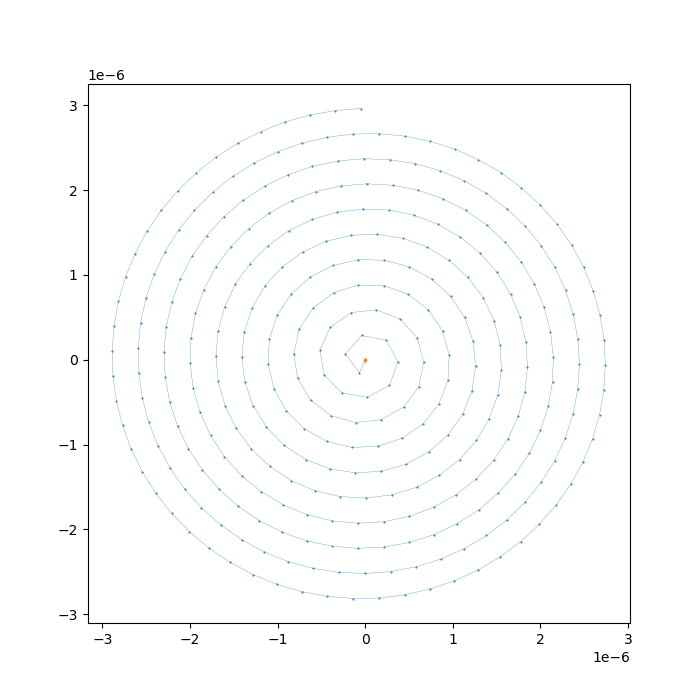

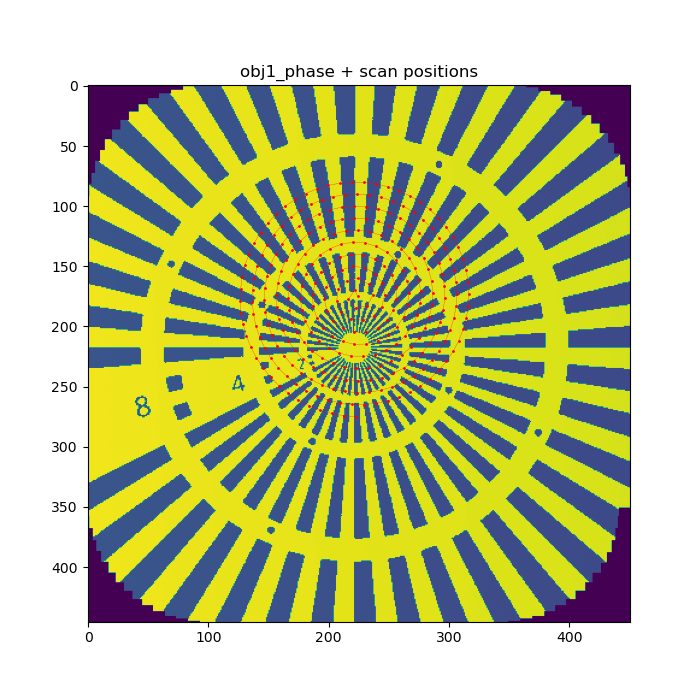

ValueError: operands could not be broadcast together with shapes (0,256) (256,256) (0,256) 

In [48]:
# Plot scan pattern, scan+object, scan+probe
# Not working correctly?
def get_pos(fname):
    """Get the positions from chunked ptyd files"""
    with h5py.File(fname, 'r') as f:
        nrchunks = len(f['chunks'].keys())
        pos = np.array([[],[]]).T
        for k in range(nrchunks):
            pos = np.concatenate((pos, f['chunks'][str(k)]['positions'][:]))
    return pos

# Plot positions
def plot_pos(pos):
    plt.figure(figsize=(7,7))
    plt.plot(pos[:,0], pos[:,1], '.-', markersize=1, linewidth=0.2)
    plt.plot(pos[0,0], pos[0,1], 'd', markersize=2)
    plt.show()
    
# Get the fnames of files containing the positions:
fname1_pos = glob.glob(fname1.rsplit('/',2)[0] + '/data/*.ptyd')[0]
fname2_pos = glob.glob(fname2.rsplit('/',2)[0] + '/data/*.ptyd')[0]
#fname3_pos = glob.glob(fname3.rsplit('/',2)[0] + '/data/*.ptyd')[0]
# Get the positions
pos1 = get_pos(fname1_pos)
pos2 = get_pos(fname2_pos)
#pos3 = get_pos(fname3_pos)

print(obj1_psize*obj1_phase.shape[0])

plot_pos(pos1)


#plt.figure(figsize=(7,7))
figTraj, ax = plt.subplots(figsize=(7,7))
steps = 50
stepsize = 3*obj1_psize
subfigTraj = ax.imshow(obj1_phase)
#plt.xticks([0, steps*stepsize])
#plt.yticks([0, steps*stepsize])
move_pos = (np.array(obj1_phase.shape) // 2) - (np.round(pos1[-1,:]/obj1_psize) // 2) # the vector that moves positions to the center of the object
ax.plot(move_pos[0] + pos1[:,0]/(obj1_psize), move_pos[1] + pos1[:,1]/(obj1_psize), 'r.-', markersize=2, linewidth=0.2)
plt.title('obj1_phase + scan positions')
# subfigTraj.axes.set_ylim(padcol, padcol+sh1[0])
# subfigTraj.axes.set_xlim(padrow, padrow+sh1[1])
plt.show()
figTraj.savefig(fname1.rsplit('/', 2)[0] + f'/phase_and_positions{samplename[scan]}.png')


# plot probe
probe_illum = np.zeros_like(obj1_phase)
positions = np.round(np.array([move_pos[0] + pos1[:,0]/(obj1_psize), move_pos[1] + pos1[:,1]/(obj1_psize)]))
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

gsize=256
for k in range(len(positions[0,:])):
    probe_illum[int(positions[1,k]-gsize//2):int(positions[1,k]+gsize//2), int(positions[0,k]-gsize//2):int(positions[0,k]+gsize//2)] += np.abs(pr1)#makeGaussian(size=gsize, fwhm = 12, center=positions[:,k])
#probe_gaussian = makeGaussian(size=256, fwhm = 12, center=None)

fig, ax = plt.subplots(1,3,figsize=(7,7))
ax[0].imshow(np.abs(pr1))
ax[1].imshow(np.log(np.abs(pr1)))
ax[2].imshow(probe_illum)
plt.show()

In [27]:
print('obj1'.ljust(30), obj1.dtype)
print('obj1_abs'.ljust(30), str(obj1_abs.dtype).ljust(15), [np.min(obj1_abs), np.max(obj1_abs)])
print('obj1_abslog'.ljust(30), str(obj1_abslog.dtype).ljust(15), [np.min(obj1_abslog), np.max(obj1_abslog)])
print('obj1_phase'.ljust(30), str(obj1_phase.dtype).ljust(15), [np.min(obj1_phase), np.max(obj1_phase)])
print('w1'.ljust(30), w1.dtype)
print('obj1_ramp'.ljust(30), obj1_ramp.dtype)
print('ramp1'.ljust(30), ramp1.dtype)
print('obj1_phaseramp'.ljust(30), str(obj1_phaseramp.dtype).ljust(15), [np.min(obj1_phaseramp), np.max(obj1_phaseramp)])
print('obj1_phaseramp_unwrapped'.ljust(30), str(obj1_phaseramp_unwrapped.dtype).ljust(15), [np.min(obj1_phaseramp_unwrapped), np.max(obj1_phaseramp_unwrapped)])
# print(''.ljust(30), .dtype)
# print(''.ljust(30), .dtype)
# print(''.ljust(30), .dtype)



obj1                           complex64
obj1_abs                       float32         [0.44123074, 1.3255937]
obj1_abslog                    float32         [-0.8181873, 0.28186044]
obj1_phase                     float32         [-3.0991087, 2.9916906]
w1                             float64
obj1_ramp                      complex128
ramp1                          complex128
obj1_phaseramp                 float64         [-3.1415859712205814, 3.1414963155047233]
obj1_phaseramp_unwrapped       float64         [2.4007074326688587, 5.126473283031007]


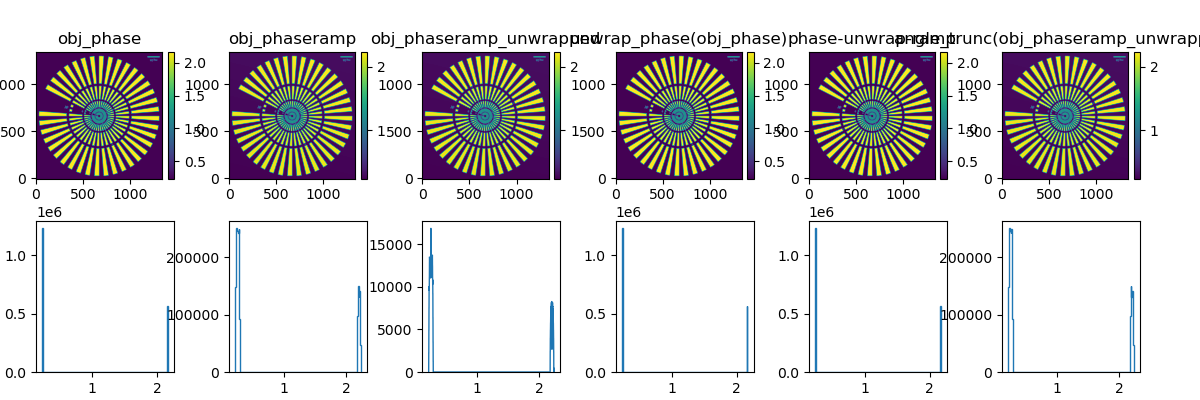

In [28]:
# GT histogram
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(2 * 6, 2*2))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
subfig24 = axs[0,0].imshow(obj_phase, origin='lower')
subfig25 = axs[0,1].imshow(obj_phaseramp, origin='lower')
subfig26 = axs[0,2].imshow(obj_phaseramp_unwrapped, origin='lower')
subfig27 = axs[0,3].imshow(unwrap_phase(obj_phase), origin='lower')
subfig29 = axs[0,4].imshow(np.abs(rmphaseramp(unwrap_phase(obj_phase), 'abs')), origin='lower')
subfig30 = axs[0,5].imshow(angle_trunc(obj_phaseramp_unwrapped), origin='lower')

plt.colorbar(subfig24, ax=axs[0,0], fraction=0.046, pad=0.04)
plt.colorbar(subfig25, ax=axs[0,1], fraction=0.046, pad=0.04)
plt.colorbar(subfig26, ax=axs[0,2], fraction=0.046, pad=0.04)
plt.colorbar(subfig27, ax=axs[0,3], fraction=0.046, pad=0.04)
plt.colorbar(subfig29, ax=axs[0,4], fraction=0.046, pad=0.04)
plt.colorbar(subfig30, ax=axs[0,5], fraction=0.046, pad=0.04)

plt.setp(axs[0,0], title='obj_phase')                   # 'obj-> phase'
plt.setp(axs[0,1], title='obj_phaseramp')               # 'obj-> rmramp-> phase'
plt.setp(axs[0,2], title='obj_phaseramp_unwrapped')     # 'obj-> rmramp-> phase-> unwrap'
plt.setp(axs[0,3], title='unwrap_phase(obj_phase)')     # 'obj-> phase-> unwrap'
plt.setp(axs[0,4], title='phase-unwrap-ramp')            # 'obj-> phase-> unwrap-> rmramp'
plt.setp(axs[0,5], title='angle_trunc(obj_phaseramp_unwrapped)')      # 

counts, bins = np.histogram(obj_phase, bins=157)
axs[1,0].stairs(counts, bins)#.axes.set_ylim(-100,20000)
counts, bins = np.histogram(obj_phaseramp, bins=157)
axs[1,1].stairs(counts, bins)#.axes.set_ylim(-100,20000)
counts, bins = np.histogram(obj_phaseramp_unwrapped, bins=3141)
axs[1,2].stairs(counts, bins)#.axes.set_ylim(-100,20000)
counts, bins = np.histogram(unwrap_phase(obj_phase), bins=157)
axs[1,3].stairs(counts, bins)#.axes.set_ylim(-100,20000)
counts, bins = np.histogram(np.abs(rmphaseramp(unwrap_phase(obj_phase), 'abs')), bins=157)
axs[1,4].stairs(counts, bins)#.axes.set_ylim(-100,20000)
counts, bins = np.histogram(subfig30.get_array().data, bins=157)
axs[1,5].stairs(counts, bins)#.axes.set_ylim(-100,20000)
#plt.show()

# for ax in axs[1,:]:
#     ax.set_yscale('log')
#     # ax.set_ylim(-100,20000)

In [29]:
import scipy
counts, bins = np.histogram(obj_phaseramp_unwrapped, bins=157)
peak_inds , peak_heights = scipy.signal.find_peaks(counts, height=90000)
print(peak_inds , peak_heights)
print('bin peak values', bins[peak_inds[0]], bins[peak_inds[1]])
print(np.min(obj_phaseramp_unwrapped), np.max(obj_phaseramp_unwrapped))
val_range = np.max(obj_phaseramp_unwrapped) - np.min(obj_phaseramp_unwrapped)
print(np.where(counts==21619))
# lowest by eye=21619
print(counts[80], bins[80])
print(np.mean(obj_phaseramp_unwrapped))
print(np.mean(obj_phaseramp_unwrapped[np.where( (obj_phaseramp_unwrapped>bins[peak_inds[0]]) & (obj_phaseramp_unwrapped<bins[peak_inds[1]]) )]))

[  1   4 153 155] {'peak_heights': array([250863., 249673., 150710., 140681.])}
bin peak values 0.24141919646707158 0.2797501329801301
0.2286422176293854 2.2346278951461143
(array([], dtype=int64),)
0 1.250800524644279
0.8753334135422903
0.26045999860855507


In [30]:
import scipy
counts, bins = np.histogram(obj_phaseramp_unwrapped, bins=314*2)
peak_inds , peak_heights = scipy.signal.find_peaks(counts, height=10000)
print(peak_inds , peak_heights)
print('bin peak values', bins[peak_inds[0]], bins[peak_inds[1]])
print(np.min(obj_phaseramp_unwrapped), np.max(obj_phaseramp_unwrapped))
val_range = np.max(obj_phaseramp_unwrapped) - np.min(obj_phaseramp_unwrapped)
print(np.where(counts==21619))
# lowest by eye=21619
print(counts[80], bins[80])
print(np.mean(obj_phaseramp_unwrapped))
print(np.mean(obj_phaseramp_unwrapped[np.where( (obj_phaseramp_unwrapped>bins[peak_inds[0]]) & (obj_phaseramp_unwrapped<bins[peak_inds[1]]) )]))


[  4  11  18 611 614 619 622] {'peak_heights': array([66386., 71548., 67402., 34567., 39408., 38918., 35878.])}
bin peak values 0.24141919646707158 0.2637789094330224
0.2286422176293854 2.2346278951461143
(array([], dtype=int64),)
0 0.4841817943831088
0.8753334135422903
0.25234411904775933


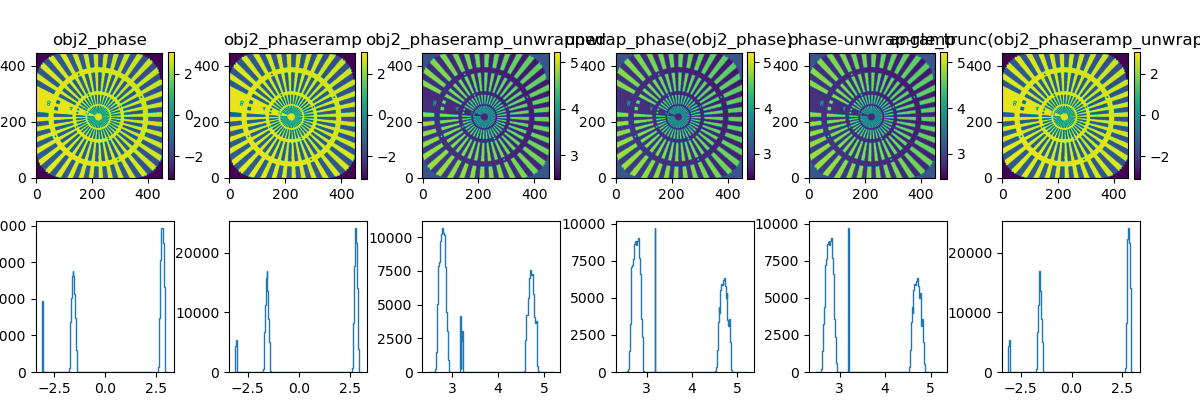

In [31]:
# Histograms
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(2 * 6, 2*2))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
subfig24 = axs[0,0].imshow(obj2_phase, origin='lower')
subfig25 = axs[0,1].imshow(obj2_phaseramp, origin='lower')
subfig26 = axs[0,2].imshow(obj2_phaseramp_unwrapped, origin='lower')
subfig27 = axs[0,3].imshow(unwrap_phase(obj2_phase), origin='lower')
subfig29 = axs[0,4].imshow(np.abs(rmphaseramp(unwrap_phase(obj2_phase), w2)), origin='lower')
subfig30 = axs[0,5].imshow(angle_trunc(obj2_phaseramp_unwrapped), origin='lower')

plt.colorbar(subfig24, ax=axs[0,0], fraction=0.046, pad=0.04)
plt.colorbar(subfig25, ax=axs[0,1], fraction=0.046, pad=0.04)
plt.colorbar(subfig26, ax=axs[0,2], fraction=0.046, pad=0.04)
plt.colorbar(subfig27, ax=axs[0,3], fraction=0.046, pad=0.04)
plt.colorbar(subfig29, ax=axs[0,4], fraction=0.046, pad=0.04)
plt.colorbar(subfig30, ax=axs[0,5], fraction=0.046, pad=0.04)

plt.setp(axs[0,0], title='obj2_phase')                   # 'obj-> phase'
plt.setp(axs[0,1], title='obj2_phaseramp')               # 'obj-> rmramp-> phase'
plt.setp(axs[0,2], title='obj2_phaseramp_unwrapped')     # 'obj-> rmramp-> phase-> unwrap'
plt.setp(axs[0,3], title='unwrap_phase(obj2_phase)')     # 'obj-> phase-> unwrap'
plt.setp(axs[0,4], title='phase-unwrap-ramp')            # 'obj-> phase-> unwrap-> rmramp'
plt.setp(axs[0,5], title='angle_trunc(obj2_phaseramp_unwrapped)')      # 

counts, bins = np.histogram(obj2_phase, bins=157)
axs[1,0].stairs(counts, bins)
counts, bins = np.histogram(obj2_phaseramp, bins=157)
axs[1,1].stairs(counts, bins)
counts, bins = np.histogram(obj2_phaseramp_unwrapped, bins=157)
axs[1,2].stairs(counts, bins)
counts, bins = np.histogram(unwrap_phase(obj2_phase), bins=157)
axs[1,3].stairs(counts, bins)
counts, bins = np.histogram(np.abs(rmphaseramp(unwrap_phase(obj2_phase), w2)), bins=157)
axs[1,4].stairs(counts, bins)
counts, bins = np.histogram(subfig30.get_array().data, bins=157)
axs[1,5].stairs(counts, bins)



# for ax in axs[1,:]:
#     ax.set_yscale('log')
#     # ax.set_ylim(-100,20000)

#fig.savefig(fname2.rsplit('/', 2)[0] + f'/hist{lable}.png')

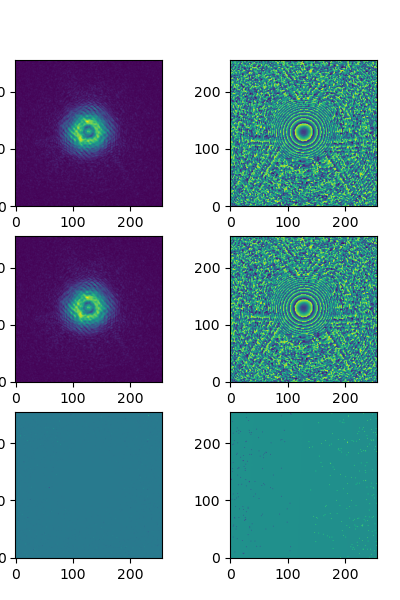

In [32]:
# Probe plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 2, 3*2))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
axs[0,0].imshow(np.abs(pr), origin='lower')
axs[0,1].imshow(np.angle(pr), origin='lower')
axs[1,0].imshow(np.abs(pr1), origin='lower')
axs[1,1].imshow(np.angle(pr1), origin='lower')

subfig24 = axs[2,0].imshow(diff1_pr_abs, origin='lower')
subfig25 = axs[2,1].imshow(diff1_pr_phase, origin='lower')

plt.show()

/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_recons/from_simg_256px_Au-Si3N4_step10px_1e+10_poisTRUE_spiral_00/simg_startframe1____fpb25_GTpr-update_00
VMIN1 = 0.7775332211140397,  VMAX1 = 1.1282421487692884,  VMIN2 = -3.4827672416580597,  VMAX2 = 5.563388585639153
Saving image to /.../ptyrplots/4692_DM_pycuda.png
Saving image to /.../ptyrplots/Frames_per_iteration.png


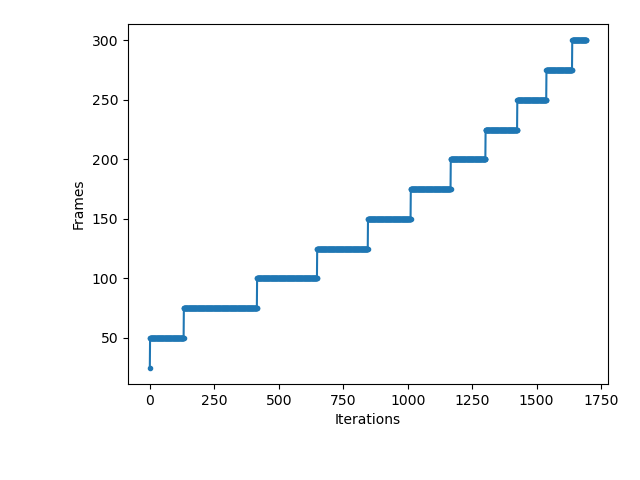

/data/staff/nanomax/reblex/data-simulated-recons/Siemens-img/simulated_recons/from_simg_256px_Au-Si3N4_step10px_1e+10_poisTRUE_spiral_00/simg_startframe1____fpb25_GTpr-update_00



In [33]:
def ptyrplot(path, plot_rec=True, plot_dumps=False, phase_shift=0, ramp=True, plot_traj=False, plot_err=False, plot_frames_per_iter=False, **kwargs):
    """
    :param path: base path of where the path/rec and path/dumps are.
    :param plot_traj:
    :param plot_err:
    :param kwargs:
    :return:
    """
    plt.ioff()
    if not os.path.exists(path+'/ptyrplots/'):
        os.mkdir(path+'/ptyrplots/')

    dumpfilenames = glob.glob(path + '/dumps/*')
    recfilenames = glob.glob(path + '/rec/*')
    filenames = []

    if plot_rec:
        filenames.extend(recfilenames)
    if plot_dumps:
        filenames.extend(dumpfilenames)

    ######## Load data ########
    obj, probe = [], []
    obj_phase = []
    ramps = []

    # for fname in filenames:
    #     if ramp:
    #         obj.append(rmphaseramp(io.h5read(fname, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0]))
    #     else:
    #         obj.append(io.h5read(fname, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0])
    #     probe.append(io.h5read(fname, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'])

    for n, fname in enumerate(filenames):
        obj.append(io.h5read(fname, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0])
        if ramp:
            weights = np.zeros_like(obj[n])
            M, N = weights.shape
            weights[M // 3:M // 3 * 2, N // 3:N // 3 * 2] = 1
            ob, phaseramp = rmphaseramp(obj[n], weight=weights, return_phaseramp=True)
            obj[n] = ob
            ramps.append(phaseramp)
        else:
            obj.append(io.h5read(fname, 'content/obj/Sscan00G00/data')['content/obj/Sscan00G00/data'][0])
        probe.append(io.h5read(fname, 'content/probe/Sscan00G00/data')['content/probe/Sscan00G00/data'])

    angle_trunc = lambda a: (a + np.ceil(abs(a) / (2 * np.pi)) * 2 * np.pi + np.pi) % (np.pi * 2) - np.pi # sets an array of radians into the interval (-pi, pi)
    ######## Plot data ########
    fcols = 2 + len(probe[0]) if len(probe) > 0 else 0 # Depends on number of probe modes
    for k, fname in enumerate(filenames):
        obj_phase.append(angle_trunc(np.angle(obj[k]) + phase_shift))

        fig, axs = plt.subplots(nrows=1, ncols=fcols, figsize=(4 * fcols, 4))  # figsize=(19, 4.5)
        # plt.rcParams['xtick.labelsize'] = 6
        fig.subplots_adjust(left=0.03, bottom=0.05, right=0.97, top=0.9, wspace=0.33, hspace=0.2)

        plt.setp(axs[0], title='Object')
        plt.setp(axs[1], title='Phase')
        plt.setp(axs[2], title='Phase')
        plt.setp(axs[-len(probe[0]):], title='Probe')

        engine, iteration = re.split(r'_scan_\d{6}_', fname)[-1].rstrip('.ptyr').rsplit('_', 1) # fname.split('/dump_scan_')[1][7:].rstrip('.ptyr').rsplit('_', 1)
        fig.suptitle(f'{engine}, Iteration {iteration}')
        VMAX1 = np.mean(np.abs(obj[k])) + 1 * np.std(np.abs(obj[k]))
        VMIN1 = np.mean(np.abs(obj[k])) - 1 * np.std(np.abs(obj[k]))
        VMAX2 = np.mean(obj_phase[k]) + 2.0 * np.std(obj_phase[k])
        VMIN2 = np.mean(obj_phase[k]) - 2.0 * np.std(obj_phase[k])
        print(f'VMIN1 = {VMIN1},  VMAX1 = {VMAX1},  VMIN2 = {VMIN2},  VMAX2 = {VMAX2}')
        #subf_0 = axs[0].imshow(abs(obj[k][0]), vmin=max(0,VMIN1), vmax=VMAX1, origin='lower', norm=mpl.colors.LogNorm(vmin=2.27e-02))
        subf_0 = axs[0].imshow(abs(obj[k]), vmin=VMIN1, vmax=VMAX1, cmap='gray', origin='lower')#, norm=mpl.colors.LogNorm(vmin=2.27e-02))
        subf_1 = axs[1].imshow(obj_phase[k], vmin=VMIN2, vmax=VMAX2, origin='lower')
        plt.colorbar(subf_0, ax=axs[0], fraction=0.046, pad=0.04)
        fig.colorbar(subf_1, ax=axs[1], fraction=0.046, pad=0.04)
        for i in range(2, 2 + len(probe[0])):
            subf_i = axs[i].imshow(abs(probe[k][i - 2]), origin='lower', norm=mpl.colors.LogNorm(vmin=2.27e-02))
            fig.colorbar(subf_i, ax=axs[i], fraction=0.046, pad=0.04)
        print(f'Saving image to /.../ptyrplots/{iteration}_{engine}.png')
        fig.savefig(f'{path}/ptyrplots/{iteration}_{engine}.png', dpi=300)
        fig.clear()


    if plot_traj:
        ptydfile = glob.glob(path + '/data/*.ptyd')
        chunks = io.h5read(ptydfile, 'chunks')[0]['chunks']
        pos = []
        for k in range(len(chunks)):
            # pos[k*50:(k+1)*50, :] = chunks[str(k)]['positions']
            pos.extend(list(chunks[str(k)]['positions']))
        pos = np.array(pos)

        fig_pos = plt.figure(figsize=(9, 9))
        plt.plot(pos[:, 0], pos[:, 1], '.-', lw=0.2)
        plt.plot(pos[0, 0], pos[0, 1], 'k.')
        plt.title(f'Scan trajectory, {pos.__len__()} positions')

        # If position refinement was used and positions were saved, then plot both original and refined positions
        try:
            # Load data only from the latest iteration
            iterations = [int(fname.split('/rec_scan_')[1][7:].rstrip('.ptyr').rsplit('_', 1)[1]) for fname in recfilenames]
            index = iterations.index(max(iterations))
            lastfilename = recfilenames[index]
            posref = io.h5read(lastfilename, 'content/positions/Sscan00G00')['content/positions/Sscan00G00']
            plt.plot(posref[:, 0], posref[:, 1], '.')
            ####
            if (pos == posref).all():
                print('No difference with position refinement!')
                plt.title(f'{fig_pos.axes[0].title.get_text()}\nNo difference with position refinement!')
            else:
                plt.title(f'{fig_pos.axes[0].title.get_text()}\nLargest change in position is {np.max(np.linalg.norm(posref-pos, axis=1))} m')
                print(f'Largest change in position is {np.max(np.linalg.norm(posref-pos, axis=1))}')
            ####
        except:
            pass
        print(f'Saving image to /.../ptyrplots/Positions.png')
        fig_pos.savefig(f'{path}/ptyrplots/Positions.png')


    if plot_err:
        for fname in recfilenames:
            iterinfo = io.h5read(fname, 'content/runtime/iter_info')['content/runtime/iter_info']
            engine, iteration = fname.split('/rec_scan_')[1][7:].rstrip('.ptyr').rsplit('_', 1)
            err = np.array([[it['error'][0], it['error'][1], it['error'][2]] for it in iterinfo])
            iter = np.array([it['iterations'] for it in iterinfo])
            fig_err = plt.figure()
            plt.plot(iter, err[:, 0]/np.max(err[:, 0]))
            plt.plot(iter, err[:, 1]/np.max(err[:, 1]))
            plt.plot(iter, err[:, 2]/np.max(err[:, 2]))
            plt.title('Normalized errors')
            plt.xlabel('Iteration')
            plt.legend(['fourier', 'photons', 'exit'])
            print(f'Saving image to /.../ptyrplots/Error_{iteration}_{engine}.png')
            fig_err.savefig(f'{path}/ptyrplots/Error_{iteration}_{engine}.png')


    if plot_frames_per_iter:
        # /home/reblex/Documents/Reconstructions/NM_scannr_1190/livesim_scannr1190_fpb20_startframe1____itcont1_00/backtrace-summary_2023-11-17_14:46:18.txt
        fname = glob.glob(path + '/backtrace-summary*')[0]
        with open(fname, 'r') as f:
            fpi_str = f.read()
        fpi_data_flattened = [int(s) for s in re.findall(r'\b\d+\b', fpi_str)]
        frames = fpi_data_flattened[::2]
        iter = fpi_data_flattened[1::2]
        # ToDo: Add last data point manually since it's not writte to file.

        fig_fpi, ax_fpi = plt.subplots()
        fig_fpi.figsize = (30,14)
        fig_fpi.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.95, wspace=0.40, hspace=0.2)
        ax_fpi.plot(iter, frames, '.-')
        ax_fpi.set_xlabel('Iterations')
        ax_fpi.set_ylabel('Frames')
        print(f'Saving image to /.../ptyrplots/Frames_per_iteration.png')
        fig_fpi.savefig(f'{path}/ptyrplots/Frames_per_iteration.png', dpi=300)
        plt.show()

    #return obj, probe  # , fig, axs


dir = fname2.rsplit('/',2)[0]
path = dir
print(path)

plot_rec=True
plot_dumps=False
phase_shift=0#3.14
ramp=True
plot_traj=False
plot_err=False
plot_frames_per_iter=True

#ptyrplot(dir, plot_rec=True, plot_dumps=True, phase_shift=np.pi/3, ramp=True, plot_traj=True, plot_err=True, plot_frames_per_iter=True)
ptyrplot(dir, plot_rec=plot_rec, plot_dumps=plot_dumps, phase_shift=phase_shift, ramp=ramp, plot_traj=plot_traj, plot_err=plot_err, plot_frames_per_iter=plot_frames_per_iter)

print(path)
print('')

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 2, 3*2))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.95, top=0.9, wspace=0.40, hspace=0.2)
axs[0].imshow(np.abs(obj)[marg:-marg,marg:-marg], interpolation='None')
axs[1].imshow(np.angle(obj)[marg:-marg,marg:-marg], interpolation='None')
marg

1